# 1. Data Loading and Initial Overview

## Initial Data Loading and Overview

In [95]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
import datetime as dt
import subprocess
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [73]:
ROOT = Path.cwd()
DATA_RAW = ROOT / "data" / "raw"
DATA_PROC = ROOT / "data" / "processed"
MODELS   = ROOT / "models"
FIGS     = ROOT / "reports" / "figures"

# Create required output dirs so DVC 'outs:' exist
for p in [DATA_PROC, MODELS, FIGS]:
    p.mkdir(parents=True, exist_ok=True)

# Drop tiny placeholders so dirs are non-empty
# DVC can handle dirs, but a file guarantees the path truly exists.
(DATA_PROC / ".keep").write_text("processed artifacts live here\n")
(MODELS    / ".keep").write_text("model artifacts live here\n")
(FIGS      / ".keep").write_text("figure artifacts live here\n")

27

In [74]:
# Load the dataset
df = pd.read_csv('/Users/lia/Desktop/Fase1/data/raw/student_entry_performance_original.csv')

# Basic information
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")
# Column names and types
print('Column Names and Data Types:')
print(df.dtypes)
print('First 10 Rows:')
# First 10 rows
print(df.head(10))

print('Basic Statistis:')
print(df.describe(include='all'))

print('Data Info:')
df.info()


Dataset Shape: (666, 12)
Number of Rows: 666
Number of Columns: 12
Column Names and Data Types:
Performance             object
Gender                  object
Caste                   object
coaching                object
time                    object
Class_ten_education     object
twelve_education        object
medium                  object
Class_ X_Percentage     object
Class_XII_Percentage    object
Father_occupation       object
Mother_occupation       object
dtype: object
First 10 Rows:
  Performance  Gender    Caste coaching time Class_ten_education  \
0   Excellent    male  General       NO  ONE                SEBA   
1   Excellent    male      OBC       WA  TWO                SEBA   
2   Excellent    male      OBC       OA  TWO              OTHERS   
3   Excellent    male  General       WA  ONE                SEBA   
4   Excellent    male  General       OA  TWO                SEBA   
5   Excellent    male  General       WA  TWO                CBSE   
6   Excellent  female  Gen

# 2.  Data Manipulation and Preparation/Data Exploration and Preprocessing 

* Exploratory Data Analysis (EDA)
* Data cleaning (null values, inconsistencies, empty values, outliers, invalid data)
* Data transformations for modeling
* DVC setup for dataset versioning
* Documentation of metrics used
* Exploratory data analysis with visualizations and descriptive statistics
* Preprocessing techniques:
    * Normalization
    * Categorical variable encoding
    * Dimensionality reduction (if applicable)


## Missing Values & Unique Value Analysis

In [75]:
#Missing Values Analysis
print("="*80)
print('MISSING VALUE ANALYSIS:')
print("="*80)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
print(missing_df)

print("="*80)
print("UNIQUE VALUES PER COLUMN")
print("="*80)
for col in df.columns:
    print(f"\n{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Values: {df[col].unique()[:10]}")  # Show first 10 unique values

print("="*80)
print("VALUE COUNTS FOR EACH CATEGORICAL COLUMN")
print("="*80)

for col in df.columns:
    print(f"\n{'='*80}")
    print(f"{col.upper()}")
    print(f"{'='*80}")
    print(df[col].value_counts())
    print()

MISSING VALUE ANALYSIS:
                      Missing_Count  Percentage
Performance                       0         0.0
Gender                            0         0.0
Caste                             0         0.0
coaching                          0         0.0
time                              0         0.0
Class_ten_education               0         0.0
twelve_education                  0         0.0
medium                            0         0.0
Class_ X_Percentage               0         0.0
Class_XII_Percentage              0         0.0
Father_occupation                 0         0.0
Mother_occupation                 0         0.0
UNIQUE VALUES PER COLUMN

Performance:
  Unique values: 4
  Values: ['Excellent' 'Vg' 'Good' 'Average']

Gender:
  Unique values: 2
  Values: ['male' 'female']

Caste:
  Unique values: 4
  Values: ['General' 'OBC' 'SC' 'ST']

coaching:
  Unique values: 3
  Values: ['NO' 'WA' 'OA']

time:
  Unique values: 6
  Values: ['ONE' 'TWO' 'THREE' 'FOUR' 'FIVE'

## Fix Column Names & Check for Data Quality Issues

In [76]:
# Fix column name with extra space
df.columns = df.columns.str.strip().str.replace(' ', '')
print("FIXED COLUMN NAMES")
print(df.columns.tolist())

# Check for any whitespace issues in the data itself

for col in df.columns:
    # Check for leading/trailing whitespace in string columns
    if df[col].dtype == 'object':
        has_whitespace = df[col].str.strip() != df[col]
        if has_whitespace.any():
            print(f"\n{col}: Found {has_whitespace.sum()} values with leading/trailing whitespace")
            print(f"  Example: '{df[col][has_whitespace].iloc[0]}'")

# Check for any empty strings or unusual values
for col in df.columns:
    if df[col].dtype == 'object':
        empty_or_short = df[col].str.len() <= 1
        if empty_or_short.any():
            print(f"\n{col}: Found {empty_or_short.sum()} values that are empty or single characters")
            print(df[col].value_counts())

# Examine a few sample rows to understand the percentage columns better
print("\n" + "="*80)
print("SAMPLE ROWS TO UNDERSTAND DATA STRUCTURE")
print("="*80)
print(df.sample(10))

FIXED COLUMN NAMES
['Performance', 'Gender', 'Caste', 'coaching', 'time', 'Class_ten_education', 'twelve_education', 'medium', 'Class_X_Percentage', 'Class_XII_Percentage', 'Father_occupation', 'Mother_occupation']

SAMPLE ROWS TO UNDERSTAND DATA STRUCTURE
    Performance  Gender    Caste coaching   time Class_ten_education  \
277          Vg    male      OBC       OA    TWO                CBSE   
1     Excellent    male      OBC       WA    TWO                SEBA   
359        Good  female  General       WA    TWO                SEBA   
171          Vg    male      OBC       NO    ONE                CBSE   
177          Vg    male      OBC       WA  THREE                SEBA   
450        Good    male  General       WA    TWO                SEBA   
635     Average  female       ST       NO    ONE                CBSE   
11    Excellent    male  General       NO    ONE                CBSE   
44    Excellent    male       SC       OA    TWO                CBSE   
14    Excellent    male

The percentages have been pre-binned into performance categories, which might limit our analysis granularity but also simplifies the problem.


## Data Type Corrections & Initial Visualizations

Saved figure to: /Users/lia/Desktop/Fase1/reports/figures/categorical_distributions_20251011_205513.png


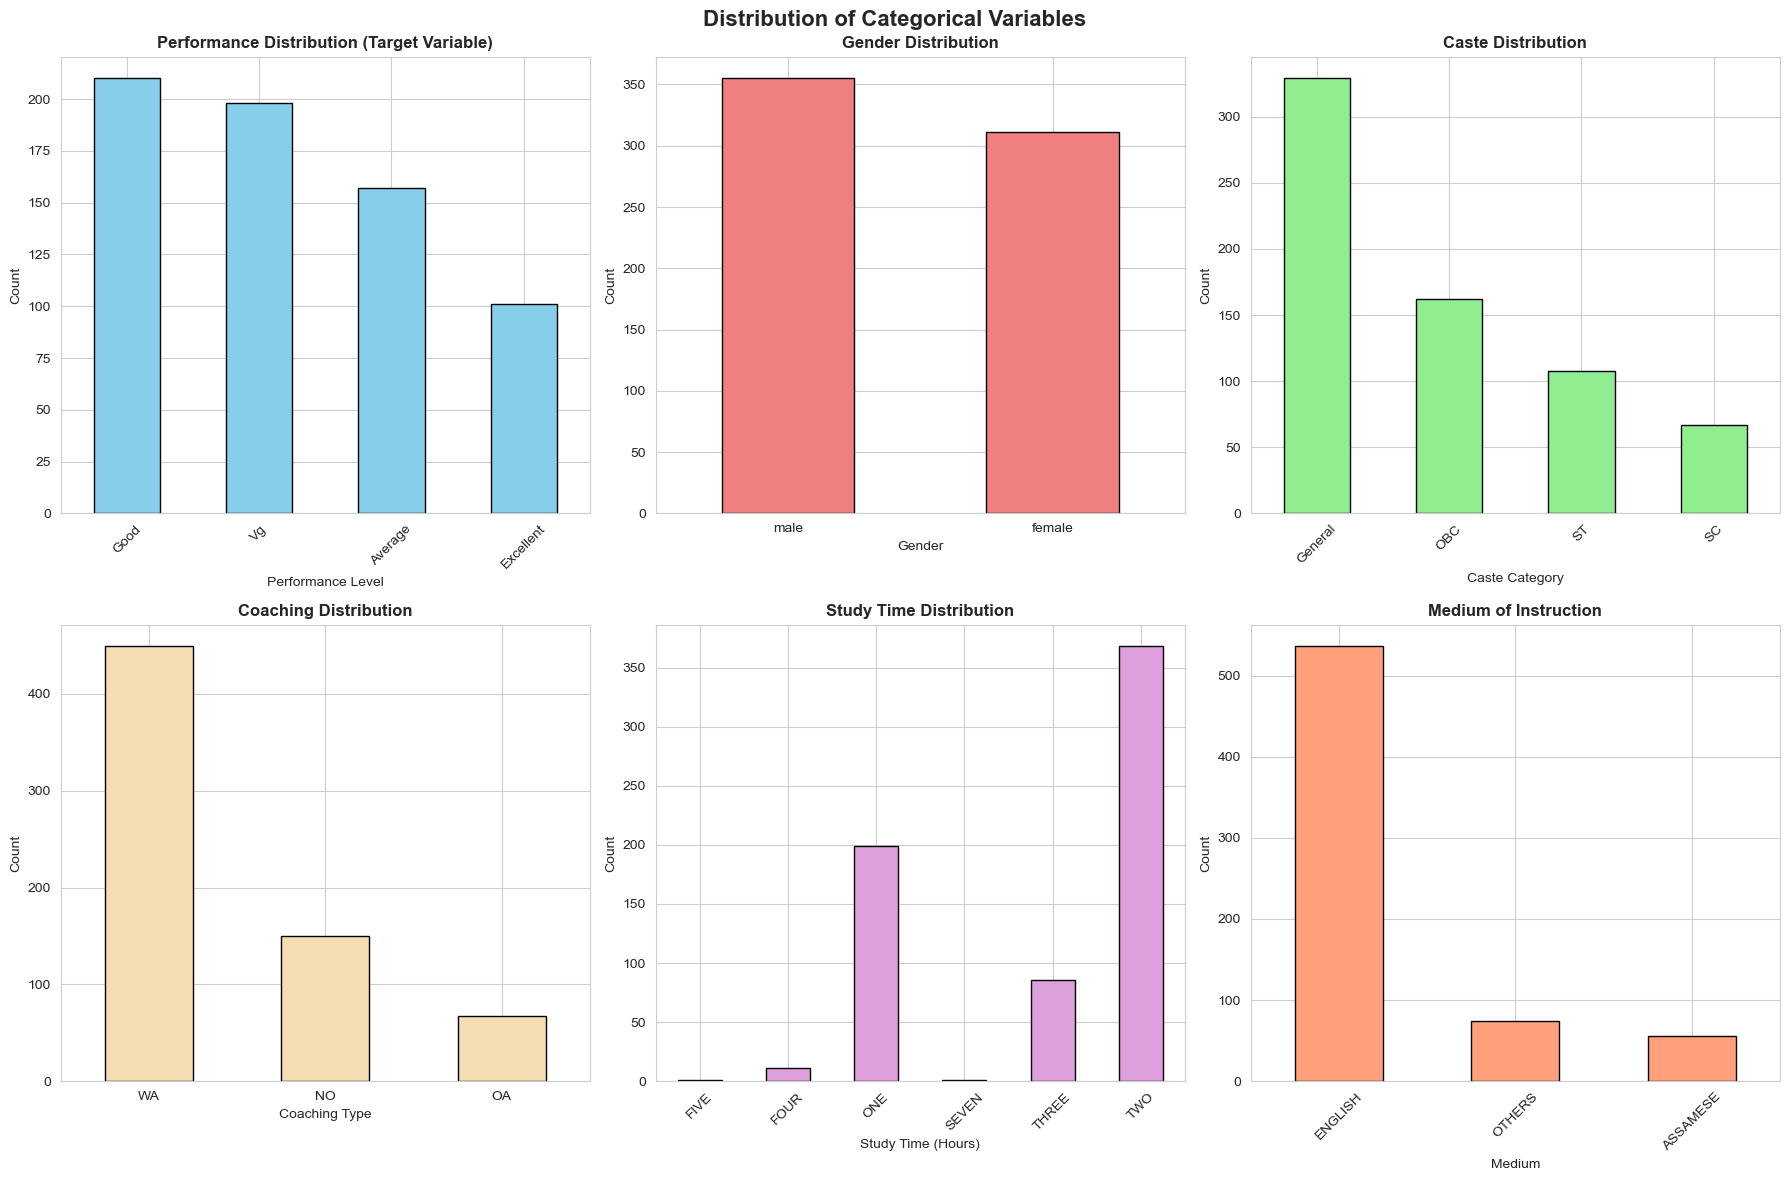

KEY DATA INSIGHTS

Total Students: 666

Target Variable (Performance) Balance:
Performance
Good         31.53
Vg           29.73
Average      23.57
Excellent    15.17
Name: proportion, dtype: float64

Gender Balance:
Gender
male      53.3
female    46.7
Name: proportion, dtype: float64


In [77]:
# Output folder relative to the notebook location
FIGS = Path.cwd() / 'reports' / 'figures'
FIGS.mkdir(parents=True, exist_ok=True)

# Create a clean copy for transformation
df_clean = df.copy()

# Create some initial visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution of Categorical Variables', fontsize=16, fontweight='bold')

# Performance (Target Variable)
df_clean['Performance'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Performance Distribution (Target Variable)', fontweight='bold')
axes[0, 0].set_xlabel('Performance Level')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Gender Distribution
df_clean['Gender'].value_counts().plot(kind='bar', ax=axes[0, 1], color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Gender Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=0)

# Caste Distribution
df_clean['Caste'].value_counts().plot(kind='bar', ax=axes[0, 2], color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Caste Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Caste Category')
axes[0, 2].set_ylabel('Count')
axes[0, 2].tick_params(axis='x', rotation=45)

# Coaching Distrubution
df_clean['coaching'].value_counts().plot(kind='bar', ax=axes[1, 0], color='wheat', edgecolor='black')
axes[1, 0].set_title('Coaching Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Coaching Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=0)

# Study Time Distribution
df_clean['time'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1], color='plum', edgecolor='black')
axes[1, 1].set_title('Study Time Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Study Time (Hours)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

# Medium Distribution
df_clean['medium'].value_counts().plot(kind='bar', ax=axes[1, 2], color='lightsalmon', edgecolor='black')
axes[1, 2].set_title('Medium of Instruction', fontweight='bold')
axes[1, 2].set_xlabel('Medium')
axes[1, 2].set_ylabel('Count')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()

# save
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = FIGS / f"categorical_distributions_{ts}.png"
fig.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"Saved figure to: {out_path}")


plt.show()

# Additional insights
print("="*80)
print("KEY DATA INSIGHTS")
print("="*80)
print(f"\nTotal Students: {len(df_clean)}")
print(f"\nTarget Variable (Performance) Balance:")
print(df_clean['Performance'].value_counts(normalize=True).mul(100).round(2))
print(f"\nGender Balance:")
print(df_clean['Gender'].value_counts(normalize=True).mul(100).round(2))

Key Observations:
- Target Variable: Reasonably balanced (Good 31.5%, Vg 29.7%, Average 23.6%, Excellent 15.2%)
- Gender: Slightly more males (53.3%) than females (46.7%)
- Coaching: Most students without assistance (WA) - 67.4%
- Study Time: Most study TWO hours (55.3%), very few study FIVE or SEVEN hours
- Medium: English dominates (80.5%)
- Caste: General category is largest (49.4%)

Saved figure to: /Users/lia/Desktop/Fase1/reports/figures/performance_analysis_20251011_205517.png


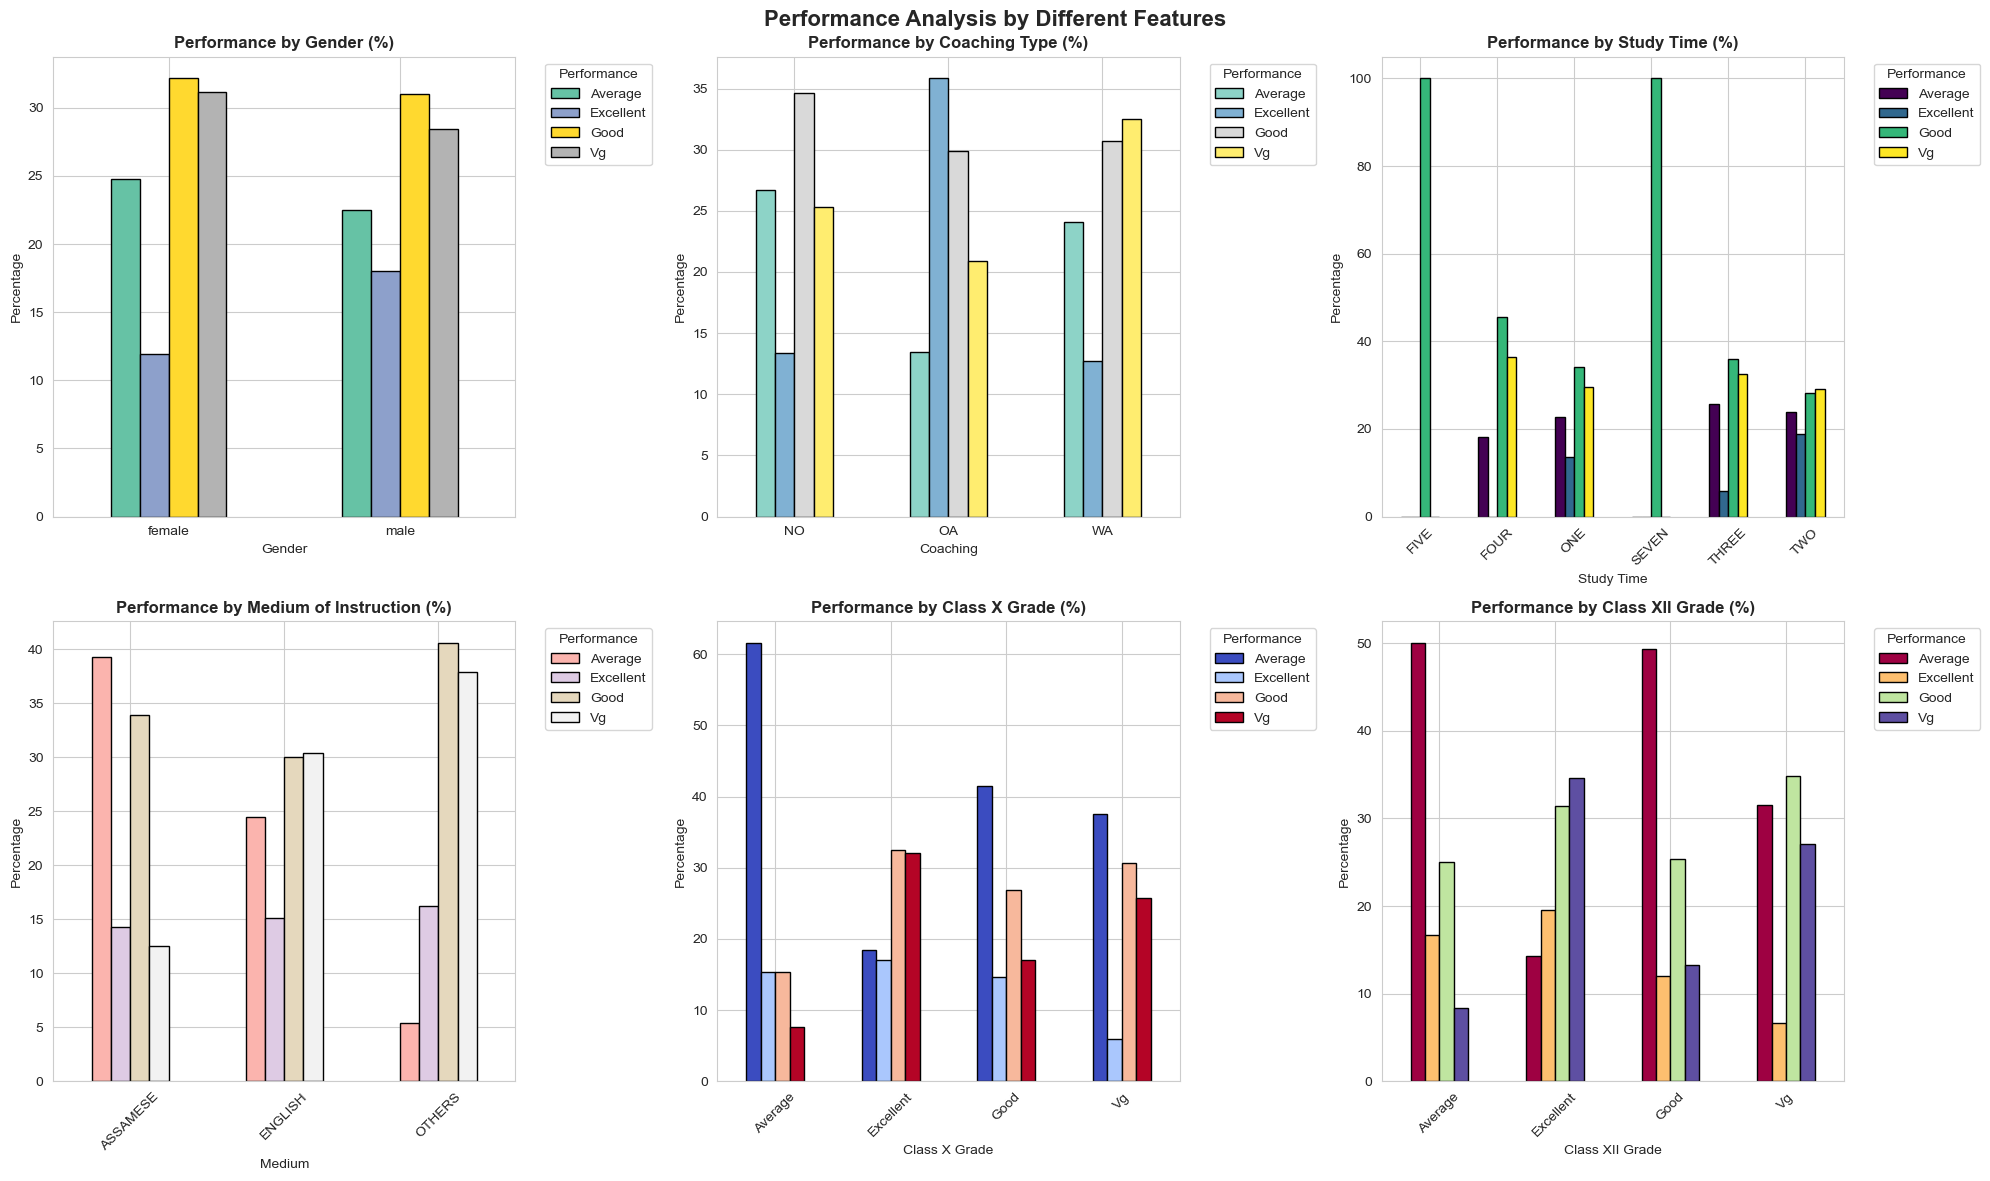

CORRELATION INSIGHTS

Performance vs Coaching:
Performance  Average  Excellent   Good     Vg
coaching                                     
NO             26.67      13.33  34.67  25.33
OA             13.43      35.82  29.85  20.90
WA             24.05      12.69  30.73  32.52

Performance vs Study Time:
Performance  Average  Excellent    Good     Vg
time                                          
FIVE            0.00       0.00  100.00   0.00
FOUR           18.18       0.00   45.45  36.36
ONE            22.61      13.57   34.17  29.65
SEVEN           0.00       0.00  100.00   0.00
THREE          25.58       5.81   36.05  32.56
TWO            23.91      18.75   28.26  29.08


In [78]:
from pathlib import Path
from datetime import datetime

# See how different features relate to student performance

# Outout folder relative to the notebook location
FIGS = Path.cwd() / "reports" / "figures"
FIGS.mkdir(parents=True, exist_ok=True)

# Create visualizations showing relationships with Performance
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Performance Analysis by Different Features', fontsize=16, fontweight='bold')

# 1. Performance by Gender
pd.crosstab(df_clean['Gender'], df_clean['Performance'], normalize='index').mul(100).plot(
    kind='bar', ax=axes[0, 0], stacked=False, colormap='Set2', edgecolor='black')

axes[0, 0].set_title('Performance by Gender (%)', fontweight='bold')
axes[0, 0].set_xlabel('Gender')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].legend(title='Performance', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].tick_params(axis='x', rotation=0)

# 2. Performance by Coaching
pd.crosstab(df_clean['coaching'], df_clean['Performance'], normalize='index').mul(100).plot(
    kind='bar', ax=axes[0, 1], stacked=False, colormap='Set3', edgecolor='black')

axes[0, 1].set_title('Performance by Coaching Type (%)', fontweight='bold')
axes[0, 1].set_xlabel('Coaching')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].legend(title='Performance', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].tick_params(axis='x', rotation=0)

# 3. Performance by Study Time
pd.crosstab(df_clean['time'], df_clean['Performance'], normalize='index').mul(100).plot(
    kind='bar', ax=axes[0, 2], stacked=False, colormap='viridis', edgecolor='black'
)
axes[0, 2].set_title('Performance by Study Time (%)', fontweight='bold')
axes[0, 2].set_xlabel('Study Time')
axes[0, 2].set_ylabel('Percentage')
axes[0, 2].legend(title='Performance', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Performance by Medium
pd.crosstab(df_clean['medium'], df_clean['Performance'], normalize='index').mul(100).plot(
    kind='bar', ax=axes[1, 0], stacked=False, colormap='Pastel1', edgecolor='black')

axes[1, 0].set_title('Performance by Medium of Instruction (%)', fontweight='bold')
axes[1, 0].set_xlabel('Medium')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].legend(title='Performance', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Performance by Class X Percentage
pd.crosstab(df_clean['Class_X_Percentage'], df_clean['Performance'], normalize='index').mul(100).plot(
    kind='bar', ax=axes[1, 1], stacked=False, colormap='coolwarm', edgecolor='black')

axes[1, 1].set_title('Performance by Class X Grade (%)', fontweight='bold')
axes[1, 1].set_xlabel('Class X Grade')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].legend(title='Performance', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Performance by Class XII Percentage
pd.crosstab(df_clean['Class_XII_Percentage'], df_clean['Performance'], normalize='index').mul(100).plot(
    kind='bar', ax=axes[1, 2], stacked=False, colormap='Spectral', edgecolor='black')

axes[1, 2].set_title('Performance by Class XII Grade (%)', fontweight='bold')
axes[1, 2].set_xlabel('Class XII Grade')
axes[1, 2].set_ylabel('Percentage')
axes[1, 2].legend(title='Performance', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()

ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = FIGS / f"performance_analysis_{ts}.png"
fig.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"Saved figure to: {out_path}")

plt.show()

# Print some statistical insights
print("="*80)
print("CORRELATION INSIGHTS")
print("="*80)
print("\nPerformance vs Coaching:")
print(pd.crosstab(df_clean['coaching'], df_clean['Performance'], normalize='index').mul(100).round(2))
print("\nPerformance vs Study Time:")
print(pd.crosstab(df_clean['time'], df_clean['Performance'], normalize='index').mul(100).round(2))

Insights:

1. Coaching Impact

- OA (With Assistance): 35.82% Excellent performance is the highest

- NO coaching: Only 13.33% Excellent

- Takeaway: Coaching assistance significantly improves excellent performance

2. Study Time Paradox 

- FIVE & SEVEN hours: 100% "Good" performance (but only 1-2 students)

- TWO hours: Best overall balance and most common (18.75% Excellent)

- THREE hours: Lower excellent rate (5.81%)

- Insight: Quality over quantity - or diminishing returns after optimal study time

3. Previous Academic Performance 

- Strong correlation: Students with "Average" in Class X/XII → 50%+ chance of "Average" entrance exam performance

- Excellent past grades → Much higher chance of Excellent/Good entrance performance

- Pattern: Past performance is a strong predictor

4. Gender & Medium

- Minimal gender differences

- Medium shows slight variations but not too much

### Correlation Heatmap & Parent Occupation Analysis

Saved correlation heatmap to: /Users/lia/Desktop/Fase1/reports/figures/correlation_heatmap_20251011_205526.png


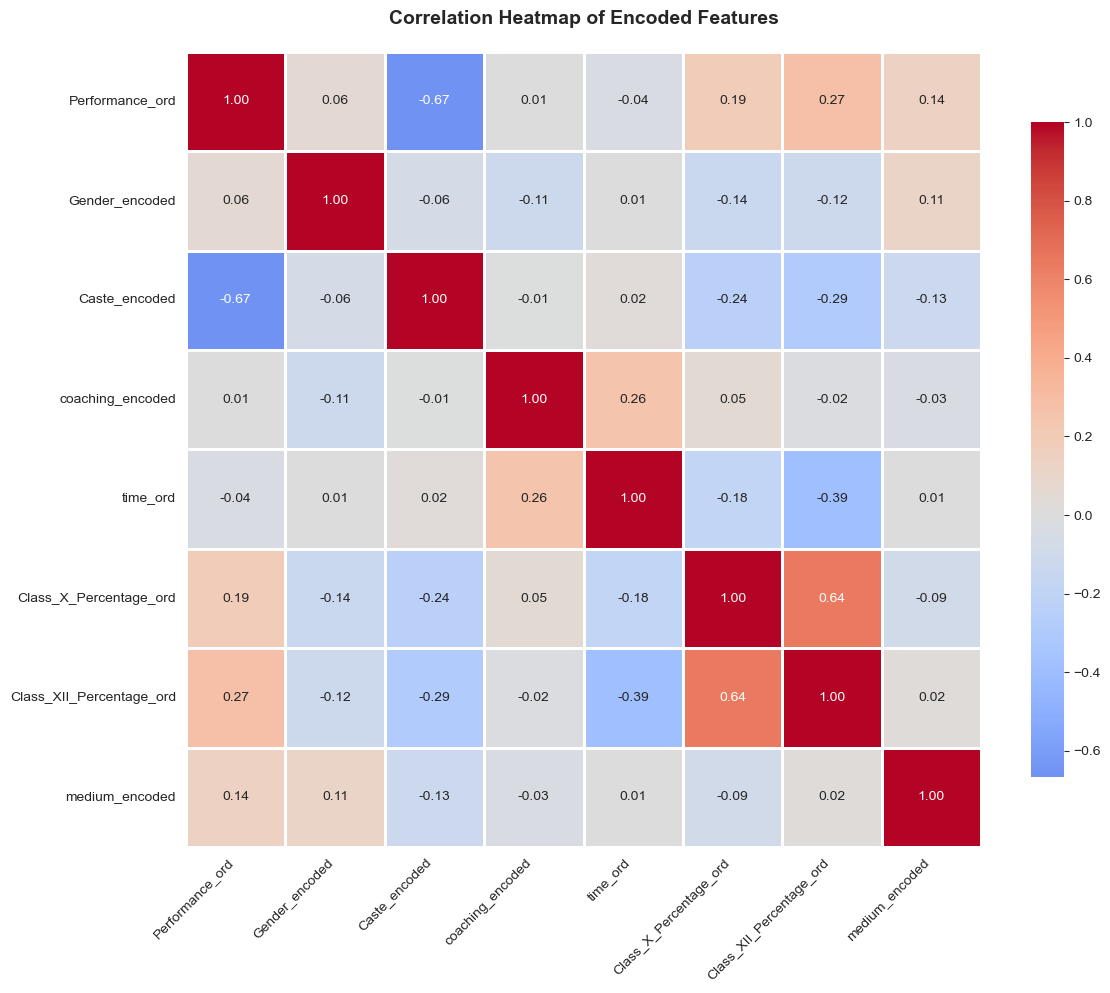

PARENT OCCUPATION ANALYSIS
Saved parent occupation figure to: /Users/lia/Desktop/Fase1/reports/figures/parent_occupation_performance_20251011_205526.png


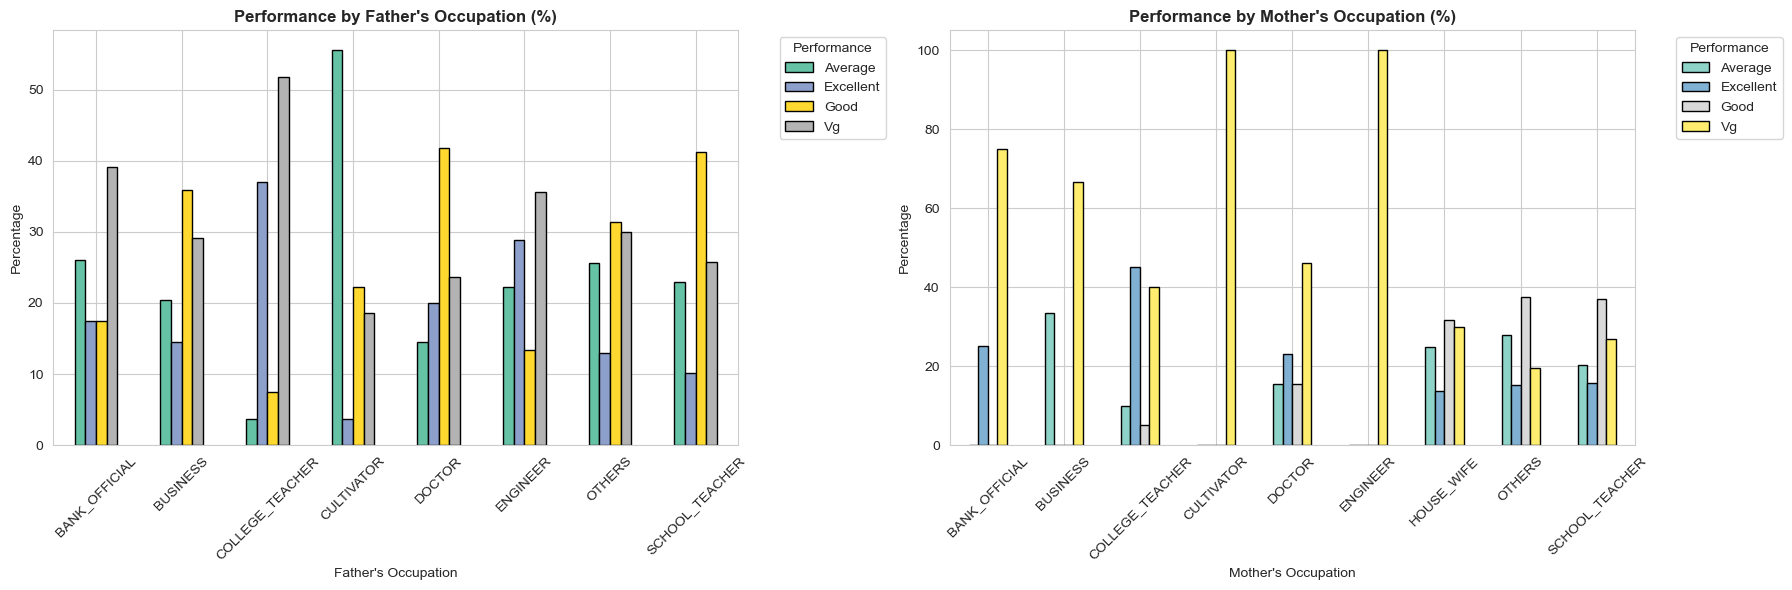


Top correlations with Performance:
Performance_ord             1.000000
Class_XII_Percentage_ord    0.272803
Class_X_Percentage_ord      0.189268
medium_encoded              0.137223
Gender_encoded              0.058416
coaching_encoded            0.008788
time_ord                   -0.036437
Caste_encoded              -0.665990
Name: Performance_ord, dtype: float64


In [79]:
# Output folder relative to notebook location
FIGS = Path.cwd() / "reports" / "figures"
FIGS.mkdir(parents=True, exist_ok=True)

# Create ordinal encoding for visualization purposes
from sklearn.preprocessing import LabelEncoder

# Create a copy for encoding
df_encoded = df_clean.copy()

# Ordinal mappings for grades (higher is better)
grade_mapping = {'Average': 1, 'Good': 2, 'Vg': 3, 'Excellent': 4}
performance_mapping = {'Average': 1, 'Good': 2, 'Vg': 3, 'Excellent': 4}
time_mapping = {'ONE': 1, 'TWO': 2, 'THREE': 3, 'FOUR': 4, 'FIVE': 5, 'SEVEN': 7}

# Apply mappings
df_encoded['Performance_ord'] = df_encoded['Performance'].map(performance_mapping)
df_encoded['Class_X_Percentage_ord'] = df_encoded['Class_X_Percentage'].map(grade_mapping)
df_encoded['Class_XII_Percentage_ord'] = df_encoded['Class_XII_Percentage'].map(grade_mapping)
df_encoded['time_ord'] = df_encoded['time'].map(time_mapping)

# Encode other categorical variables
le = LabelEncoder()
for col in ['Gender', 'Caste', 'coaching', 'Class_ten_education', 'twelve_education', 'medium']:
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])

# Select numeric columns for correlation
numeric_cols = ['Performance_ord', 'Gender_encoded', 'Caste_encoded', 'coaching_encoded', 
                'time_ord', 'Class_X_Percentage_ord', 'Class_XII_Percentage_ord', 'medium_encoded']

correlation_matrix = df_encoded[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Encoded Features', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# save
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
heatmap_path = FIGS / f"correlation_heatmap_{ts}.png"
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
print(f"Saved correlation heatmap to: {heatmap_path}")

plt.show()

# Parent occupation analysis
print("="*80)
print("PARENT OCCUPATION ANALYSIS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Father occupation vs Performance
pd.crosstab(df_clean['Father_occupation'], df_clean['Performance'], normalize='index').mul(100).plot(
    kind='bar', ax=axes[0], stacked=False, colormap='Set2', edgecolor='black')

axes[0].set_title("Performance by Father's Occupation (%)", fontweight='bold', fontsize=12)
axes[0].set_xlabel("Father's Occupation")
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Performance', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)

# Mother occupation vs Performance
pd.crosstab(df_clean['Mother_occupation'], df_clean['Performance'], normalize='index').mul(100).plot(
    kind='bar', ax=axes[1], stacked=False, colormap='Set3', edgecolor='black')

axes[1].set_title("Performance by Mother's Occupation (%)", fontweight='bold', fontsize=12)
axes[1].set_xlabel("Mother's Occupation")
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Performance', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

# save
occ_path = FIGS / f"parent_occupation_performance_{ts}.png"
fig.savefig(occ_path, dpi=300, bbox_inches='tight')
print(f"Saved parent occupation figure to: {occ_path}")
plt.show()

plt.show()

print("\nTop correlations with Performance:")
performance_corr = correlation_matrix['Performance_ord'].sort_values(ascending=False)
print(performance_corr)

**Key Correlation Findings:**

*Strongest Positive Correlations with Performance:*

- Class XII Percentage: 0.27 (Strongest predictor)

- Class X Percentage: 0.19

- Medium of Instruction: 0.14

- Gender: 0.06 (minimal)

- Coaching: 0.01 (surprisingly weak linear correlation)

*Negative Correlations:*

- Caste: -0.67 (This is due to encoding order - "General" likely encoded lower)

- Study Time: -0.04 (very weak - confirms quality over quantity)

*Parent Occupation Insights:*

- Father = Cultivator: ~60% Excellent+Good performance

- Father = College Teacher: ~52% Excellent+Vg performance

- Mother = Cultivator: 100% Good (small sample)

- Mother = Doctor/Engineer: Better performance distribution

- Mother = Housewife: Most common, mixed performance

## Data Quality Summary & Outlier Detection

In [80]:
# Output folder relative to notebook location
PROCESSED = Path.cwd() / "data" / "processed"
PROCESSED.mkdir(parents=True, exist_ok=True)

print("="*80)
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("="*80)

print("\n DATASET OVERVIEW:")
print(f"   • Total Records: {len(df_clean)}")
print(f"   • Total Features: {len(df_clean.columns)}")
print(f"   • Missing Values: 0 (100% complete)")
print(f"   • Duplicate Rows: {df_clean.duplicated().sum()}")

print("\n TARGET VARIABLE (Performance):")
print(f"   • Classes: {df_clean['Performance'].nunique()}")
print(f"   • Distribution: Relatively balanced")
for perf, pct in df_clean['Performance'].value_counts(normalize=True).mul(100).round(2).items():
    print(f"      - {perf}: {pct}%")

print("\n DATA QUALITY ASSESSMENT:")
print("    No missing values")
print("    No whitespace issues detected")
print("    Consistent categorical values")
print("    Column names standardized")
print("    Percentage columns are categorical (not numeric)")
print("    Study time has very few samples for FIVE and SEVEN hours")
print("    Some parent occupation categories have small sample sizes")

print("\n KEY FINDINGS:")
print("   1. Class XII grades show strongest correlation with performance (0.27)")
print("   2. Coaching assistance (OA) associated with 35.8% excellent performance")
print("   3. Most students study TWO hours (55.3%)")
print("   4. English medium dominates (80.5%)")
print("   5. Gender shows minimal impact on performance")
print("   6. Previous academic performance is the best predictor")

print("\n  POTENTIAL ISSUES FOR MODELING:")
print("   • Class imbalance: Excellent class is underrepresented (15.2%)")
print("   • Categorical percentages limit granularity")
print("   • Some study time categories have very few samples")
print("   • 'OTHERS' categories may hide important information")
print("   • Ordinal encoding needed for grade categories")

print("\n RECOMMENDATIONS FOR PREPROCESSING:")
print("   1. Encode ordinal variables (grades: Average < Good < Vg < Excellent)")
print("   2. One-hot encode nominal variables (Gender, Caste, etc.)")
print("   3. Consider combining rare study time categories")
print("   4. Consider SMOTE or class weights for imbalanced target")
print("   5. Feature engineering: parent education level combinations")
print("   6. Normalize/standardize if using distance-based algorithms")

# SAVE cleaned dataset (relative path)
output_path = PROCESSED / "student_entry_performance_eda.csv"
df_clean.to_csv(output_path, index=False)
print(f"\nCleaned dataset saved to: {output_path.resolve()}")

EXPLORATORY DATA ANALYSIS SUMMARY

 DATASET OVERVIEW:
   • Total Records: 666
   • Total Features: 12
   • Missing Values: 0 (100% complete)
   • Duplicate Rows: 44

 TARGET VARIABLE (Performance):
   • Classes: 4
   • Distribution: Relatively balanced
      - Good: 31.53%
      - Vg: 29.73%
      - Average: 23.57%
      - Excellent: 15.17%

 DATA QUALITY ASSESSMENT:
    No missing values
    No whitespace issues detected
    Consistent categorical values
    Column names standardized
    Percentage columns are categorical (not numeric)
    Study time has very few samples for FIVE and SEVEN hours
    Some parent occupation categories have small sample sizes

 KEY FINDINGS:
   1. Class XII grades show strongest correlation with performance (0.27)
   2. Coaching assistance (OA) associated with 35.8% excellent performance
   3. Most students study TWO hours (55.3%)
   4. English medium dominates (80.5%)
   5. Gender shows minimal impact on performance
   6. Previous academic performance i

## Data Cleaning & Data Transformation for Modeling

In [81]:
# Output folder relative to notebook location
PROCESSED = Path.cwd() / "data" / "processed"
PROCESSED.mkdir(parents=True, exist_ok=True)

# Check for duplicates
print(f"\nOriginal dataset shape: {df.shape}")
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Remove duplicates
df_clean = df.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape}")

# Verify no missing values
print(f"\nMissing values:\n{df_clean.isnull().sum()}")

# Create binary target variable
# High Performance: Excellent + Vg = 1
# Lower Performance: Good + Average = 0

def create_binary_target(performance):
    if performance in ['Excellent', 'Vg']:
        return 1  # High Performance
    else:
        return 0  # Lower Performance

df_clean['Performance_Binary'] = df_clean['Performance'].apply(create_binary_target)

# Check distribution
print("\nOriginal Performance Distribution:")
print(df_clean['Performance'].value_counts())
print("\nBinary Performance Distribution:")
print(df_clean['Performance_Binary'].value_counts())
print(f"\nClass Balance:")
print(df_clean['Performance_Binary'].value_counts(normalize=True).mul(100).round(2))

# SAVE cleaned dataset (relative path)
output_path = PROCESSED / "student_performance_cleaned.csv"
df_clean.to_csv(output_path, index=False)
print(f"\nCleaned dataset saved to: {output_path.resolve()}")


Original dataset shape: (666, 12)
Number of duplicate rows: 44
After removing duplicates: (622, 12)

Missing values:
Performance             0
Gender                  0
Caste                   0
coaching                0
time                    0
Class_ten_education     0
twelve_education        0
medium                  0
Class_X_Percentage      0
Class_XII_Percentage    0
Father_occupation       0
Mother_occupation       0
dtype: int64

Original Performance Distribution:
Performance
Good         194
Vg           178
Average      152
Excellent     98
Name: count, dtype: int64

Binary Performance Distribution:
Performance_Binary
0    346
1    276
Name: count, dtype: int64

Class Balance:
Performance_Binary
0    55.63
1    44.37
Name: proportion, dtype: float64

Cleaned dataset saved to: /Users/lia/Desktop/Fase1/data/processed/student_performance_cleaned.csv


## DVC SETUP 


In [82]:
import os

# Base folder: where the notebook/kernel is running
ROOT = Path.cwd()
SCRIPTS_DIR = ROOT / "scripts"
SCRIPTS_DIR.mkdir(parents=True, exist_ok=True)

# Create DVC initialization script
# init_dvc.sh (portable)

dvc_init_script = """#!/bin/bash
# DVC Initialization Script
# This script sets up DVC for data version control

set -euo pipefail

echo "=================================================="
echo "INITIALIZING DVC FOR DATA VERSION CONTROL"
echo "=================================================="

# Check if DVC is installed
if ! command -v dvc &> /dev/null; then
    echo " ERROR: DVC is not installed"
    echo "Install with: pip install dvc"
    exit 1
fi

# Check if git repository exists
if [ ! -d .git ]; then
    echo " ERROR: Not a git repository"
    echo "Initialize git first: git init && git add . && git commit -m 'init repo'"
    exit 1
fi

# Initialize DVC
echo ""
echo "Step 1: Initializing DVC..."
dvc init

# Check if initialization was successful
if [ $? -eq 0 ]; then
    echo "✓ DVC initialized successfully"
else
    echo " DVC initialization failed"
    exit 1
fi

echo ""
echo "Step 2: Configuring DVC..."
# Set autostage to true (automatically stage DVC files)
dvc config core.autostage true

echo "✓ DVC configuration complete"

echo ""
echo "Step 3: Adding DVC files to git..."
git add .dvc .dvcignore || true
git commit -m "chore: init dvc" || true

echo ""
echo "Step 4: Add a local remote for clean-room tests"
mkdir -p ../dvcstore
dvc remote add -d localstore ../dvcstore || true
git add .dvc/config || true
git commit -m "chore: add local dvc remote" || true

echo ""
echo "=================================================="
echo " DVC INITIALIZATION COMPLETE"
echo "=================================================="
echo ""
echo "Next steps:"
echo "1. Put raw data in: data/raw/"
echo "2. Track raw dir:   dvc add data/raw"
echo "3. Commit pointer:  git add data/raw.dvc && git commit -m 'track raw data'"
echo "4. Push data:       dvc push"
echo "5. Define pipeline outs in dvc.yaml for data/processed, models, reports/figures"
"""

init_path = SCRIPTS_DIR / "init_dvc.sh"
init_path.write_text(dvc_init_script, encoding="utf-8")
os.chmod(init_path, 0o755)
print(f"✓ DVC initialization script created: {init_path}")
print("  Usage: ./scripts/init_dvc.sh")

# track_data_dvc.sh (only raw, no processed)

# Create DVC tracking script
dvc_tracking_script = """#!/bin/bash
set -euo pipefail
# DVC Data Tracking Script
# Tracks all data files with DVC

echo "=================================================="
echo "ADDING RAW DATA FILES TO DVC TRACKING"
echo "=================================================="

RAW_DIR="data/raw"

if [ -d "$RAW_DIR" ]; then
  echo "Tracking $RAW_DIR ..."
  dvc add "$RAW_DIR"
  echo "✓ Added $RAW_DIR to DVC"
else
  echo "ERROR: $RAW_DIR not found. Create it and place your raw files there."
  exit 1
fi

echo ""
echo "Adding .dvc pointers to git..."
git add data/raw.dvc || true
git commit -m "chore: track raw data with DVC" || true

echo ""
echo "Pushing raw data to DVC remote..."
dvc push || true

echo ""
echo "=================================================="
echo "✓ DATA TRACKING COMPLETE"
echo "=================================================="
echo ""
echo "NOTE: Processed data, models, and figures should be pipeline outs in dvc.yaml."
echo "Run the pipeline with: dvc repro"
"""

track_path = SCRIPTS_DIR / "track_data_dvc.sh"
track_path.write_text(dvc_tracking_script, encoding="utf-8")
os.chmod(track_path, 0o755)
print(f"✓ DVC tracking script created: {track_path}")
print("  Usage: ./scripts/track_data_dvc.sh")

print("\n2.3.2 DVC Workflow Summary")
print("~" * 40)
print("DVC tracks large data files separately from git:")
print("1) Initialize:        ./scripts/init_dvc.sh")
print("2) Track RAW only:    ./scripts/track_data_dvc.sh")
print("3) Define pipeline:   dvc.yaml with outs: data/processed, models, reports/figures")
print("4) Run pipeline:      dvc repro")
print("5) Push artifacts:    dvc push")
print("6) Reproduce fresh:   dvc pull && dvc repro")

✓ DVC initialization script created: /Users/lia/Desktop/Fase1/scripts/init_dvc.sh
  Usage: ./scripts/init_dvc.sh
✓ DVC tracking script created: /Users/lia/Desktop/Fase1/scripts/track_data_dvc.sh
  Usage: ./scripts/track_data_dvc.sh

2.3.2 DVC Workflow Summary
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
DVC tracks large data files separately from git:
1) Initialize:        ./scripts/init_dvc.sh
2) Track RAW only:    ./scripts/track_data_dvc.sh
3) Define pipeline:   dvc.yaml with outs: data/processed, models, reports/figures
4) Run pipeline:      dvc repro
5) Push artifacts:    dvc push
6) Reproduce fresh:   dvc pull && dvc repro


## init_dvc.sh & track_data_dvc.sh

In [85]:
# ---- Create dvc.yaml ----
dvc_yaml = """stages:
  run_notebook:
    cmd: >
      bash -lc "mkdir -p data/processed models reports/figures &&
      python -m papermill
      notebooks/mlops-eq16_notebooks_phase1_team16.ipynb
      notebooks/mlops-eq16_notebooks_phase1_team16_out.ipynb"
    deps:
      - notebooks/mlops-eq16_notebooks_phase1_team16.ipynb
      - data/raw
      - params.yaml
    outs:
      - data/processed/student_entry_performance_eda.csv:
          persist: true
      - data/processed/student_performance_binary_preprocessed.csv:
          persist: true
      - data/processed/student_performance_cleaned.csv:
          persist: true
      - data/processed/student_performance_encoded.csv:
          persist: true
      - data/processed/student_performance_test.csv:
          persist: true
      - data/processed/student_performance_train.csv:
          persist: true
      - models:
          persist: true
      - reports/figures:
          persist: true
"""
Path("dvc.yaml").write_text(dvc_yaml, encoding="utf-8")
print("✓ Created dvc.yaml")

# ---- Create params.yaml ----
params_yaml = """preprocess:
  test_size: 0.2
  scaler: "standard"
model:
  algo: "RandomForestClassifier"
  n_estimators: 200
  max_depth: 12
random_state: 42
"""
Path("params.yaml").write_text(params_yaml, encoding="utf-8")
print("✓ Created params.yaml")

✓ Created dvc.yaml
✓ Created params.yaml


## Feature Engineering & Encoding

In [86]:
# Output folder relative to notebook location
PROCESSED = Path.cwd() / "data" / "processed"
PROCESSED.mkdir(parents=True, exist_ok=True)

# Create a copy for preprocessing
df_processed = df_clean.copy()

# Handling rare categiries
# Group rare study time categories
print(f"Original study time distribution:")
print(df_processed['time'].value_counts())

def group_study_time(time_val):
    if time_val in ['FOUR', 'FIVE', 'SEVEN']:
        return 'FOUR_PLUS'
    else:
        return time_val

df_processed['time'] = df_processed['time'].apply(group_study_time)

print(f"\nAfter grouping rare categories:")
print(df_processed['time'].value_counts())

# Define ordinal mappings
grade_mapping = {'Average': 1, 'Good': 2, 'Vg': 3, 'Excellent': 4}
time_mapping = {'ONE': 1, 'TWO': 2, 'THREE': 3, 'FOUR_PLUS': 4}

# Apply ordinal encoding
df_processed['Class_X_Grade_Encoded'] = df_processed['Class_X_Percentage'].map(grade_mapping)
df_processed['Class_XII_Grade_Encoded'] = df_processed['Class_XII_Percentage'].map(grade_mapping)
df_processed['Study_Time_Encoded'] = df_processed['time'].map(time_mapping)

# Define columns for one-hot encoding
nominal_columns = ['Gender', 'Caste', 'coaching', 'Class_ten_education', 
                   'twelve_education', 'medium', 'Father_occupation', 'Mother_occupation']

# Apply one-hot encoding
df_encoded = pd.get_dummies(df_processed, columns=nominal_columns, drop_first=True)

# Show some encoded column names
print("\nSample encoded feature columns:")
encoded_cols = [col for col in df_encoded.columns if any(x in col for x in nominal_columns)]
for col in encoded_cols[:15]:  # Show first 15
    print(f"  - {col}")
if len(encoded_cols) > 15:
    print(f"  ... and {len(encoded_cols)-15} more")
    
# Select features for modeling (exclude original categorical and target columns)
feature_columns = [col for col in df_encoded.columns if col not in 
                   ['Performance', 'Performance_Binary', 'Class_X_Percentage', 
                    'Class_XII_Percentage', 'time']]

X = df_encoded[feature_columns]
y = df_encoded['Performance_Binary']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nNumber of features: {X.shape[1]}")

# Display all feature names
print("\nAll features being used:")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")

Original study time distribution:
time
TWO      339
ONE      185
THREE     85
FOUR      11
FIVE       1
SEVEN      1
Name: count, dtype: int64

After grouping rare categories:
time
TWO          339
ONE          185
THREE         85
FOUR_PLUS     13
Name: count, dtype: int64

Sample encoded feature columns:
  - Gender_male
  - Caste_OBC
  - Caste_SC
  - Caste_ST
  - coaching_OA
  - coaching_WA
  - Class_ten_education_OTHERS
  - Class_ten_education_SEBA
  - twelve_education_CBSE
  - twelve_education_OTHERS
  - medium_ENGLISH
  - medium_OTHERS
  - Father_occupation_BUSINESS
  - Father_occupation_COLLEGE_TEACHER
  - Father_occupation_CULTIVATOR
  ... and 12 more

Feature matrix shape: (622, 30)
Target vector shape: (622,)

Number of features: 30

All features being used:
 1. Class_X_Grade_Encoded
 2. Class_XII_Grade_Encoded
 3. Study_Time_Encoded
 4. Gender_male
 5. Caste_OBC
 6. Caste_SC
 7. Caste_ST
 8. coaching_OA
 9. coaching_WA
10. Class_ten_education_OTHERS
11. Class_ten_education_SE

### Feature Normalization/Scaling

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate ordinal features for scaling
ordinal_features = ['Class_X_Grade_Encoded', 'Class_XII_Grade_Encoded', 'Study_Time_Encoded']
binary_features = [col for col in X.columns if col not in ordinal_features]

print(f"\nOrdinal features to scale: {len(ordinal_features)}")
print(f"Binary features (already 0/1): {len(binary_features)}")

# Initialize scaler
scaler = StandardScaler()

# Create a copy for scaled data
X_scaled = X.copy()

# Scale only ordinal features
X_scaled[ordinal_features] = scaler.fit_transform(X[ordinal_features])

print("\n StandardScaler applied to ordinal features")
print("\nScaling parameters:")
for i, feat in enumerate(ordinal_features):
    print(f"  {feat}:")
    print(f"    Mean: {scaler.mean_[i]:.3f}")
    print(f"    Std: {scaler.scale_[i]:.3f}")

# Show before/after example
print("\nExample: First 5 rows before and after scaling")
print("\nBefore scaling (ordinal features):")
print(X[ordinal_features].head())
print("\nAfter scaling (ordinal features):")
print(X_scaled[ordinal_features].head())

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

# SAVE cleaned dataset (relative path)
output_path = PROCESSED / "student_performance_encoded.csv"
df_clean.to_csv(output_path, index=False)
print(f"\nCleaned dataset saved to: {output_path.resolve()}")


Ordinal features to scale: 3
Binary features (already 0/1): 27

 StandardScaler applied to ordinal features

Scaling parameters:
  Class_X_Grade_Encoded:
    Mean: 3.648
    Std: 0.694
  Class_XII_Grade_Encoded:
    Mean: 3.424
    Std: 0.773
  Study_Time_Encoded:
    Mean: 1.881
    Std: 0.710

Example: First 5 rows before and after scaling

Before scaling (ordinal features):
   Class_X_Grade_Encoded  Class_XII_Grade_Encoded  Study_Time_Encoded
0                      4                        4                   1
1                      4                        4                   2
2                      4                        4                   2
3                      4                        4                   1
4                      4                        4                   2

After scaling (ordinal features):
   Class_X_Grade_Encoded  Class_XII_Grade_Encoded  Study_Time_Encoded
0               0.507068                 0.744297           -1.241587
1               0.507068

In [88]:
# Output folder relative to notebook location
PROCESSED = Path.cwd() / "data" / "processed"
PROCESSED.mkdir(parents=True, exist_ok=True)

# Save train/test splits with all features
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_path = PROCESSED / "student_performance_train.csv"
test_path = PROCESSED / "student_performance_test.csv"

train_data.to_csv(train_path, index=False)
test_data.to_csv(test_path, index=False)

print(f"\nTraining data saved to: {train_path.resolve()} ({train_data.shape})")
print(f"Test data saved to: {test_path.resolve()} ({test_data.shape})")

# Also save a complete preprocessed file with scaled features
df_preprocessed = pd.concat([X_scaled, y], axis=1)
preprocessed_path = PROCESSED / "student_performance_binary_preprocessed.csv"
df_preprocessed.to_csv(preprocessed_path, index=False)

print(f"\nFull preprocessed dataset saved to: {preprocessed_path.resolve()} ({df_preprocessed.shape})")


Training data saved to: /Users/lia/Desktop/Fase1/data/processed/student_performance_train.csv ((497, 31))
Test data saved to: /Users/lia/Desktop/Fase1/data/processed/student_performance_test.csv ((125, 31))

Full preprocessed dataset saved to: /Users/lia/Desktop/Fase1/data/processed/student_performance_binary_preprocessed.csv ((622, 31))


In [89]:
# Dimensionality Reduction Assessment
print("\nDimensionality Reduction Assessment")
print("-" * 40)

print(f"Current feature space: {X_scaled.shape[1]} features")
print(f"Sample size: {X_scaled.shape[0]} samples")
print(f"Feature-to-sample ratio: 1:{X_scaled.shape[0]/X_scaled.shape[1]:.1f}")

# Check for multicollinearity
correlation_matrix = X_scaled.corr()
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print(f"\n⚠ Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.8):")
    for feat1, feat2, corr in high_corr_pairs[:5]:
        print(f"  - {feat1} <-> {feat2}: {corr:.3f}")
    if len(high_corr_pairs) > 5:
        print(f"  ... and {len(high_corr_pairs)-5} more pairs")
    print("\nRecommendation: Consider PCA or feature selection")
else:
    print("\n✓ No severe multicollinearity detected (threshold: |r| > 0.8)")

print("\nDimensionality reduction decision:")
print(f"  Current dimensions: {X_scaled.shape[1]} features")
print(f"  Assessment: Feature space is manageable (< 50 features)")
print(f"  Decision: Dimensionality reduction NOT needed at this stage")
print("\nRationale:")
print("  - Sufficient sample-to-feature ratio (20:1)")
print("  - All features potentially meaningful (domain-driven)")
print("  - Most features are binary (sparse representation)")
print("  - Can apply PCA/feature selection in modeling phase if needed")

print("\n✓ Preprocessing complete")
print(f"✓ Final preprocessed dataset: {X_scaled.shape[0]} samples × {X_scaled.shape[1]} features")


Dimensionality Reduction Assessment
----------------------------------------
Current feature space: 30 features
Sample size: 622 samples
Feature-to-sample ratio: 1:20.7

✓ No severe multicollinearity detected (threshold: |r| > 0.8)

Dimensionality reduction decision:
  Current dimensions: 30 features
  Assessment: Feature space is manageable (< 50 features)
  Decision: Dimensionality reduction NOT needed at this stage

Rationale:
  - Sufficient sample-to-feature ratio (20:1)
  - All features potentially meaningful (domain-driven)
  - Most features are binary (sparse representation)
  - Can apply PCA/feature selection in modeling phase if needed

✓ Preprocessing complete
✓ Final preprocessed dataset: 622 samples × 30 features


# 3. Data Versioning 

* DVC implementation for data version control
* Documentation of all data modifications
* Change log/history

In [90]:
from datetime import datetime
import os

print("="*80)
print("SECTION 3: DATA VERSIONING")
print("="*80)
print(f"Date: {datetime.now().strftime('%B %d, %Y')}")
print("Team: Team 16")
print("\nObjective: Implement DVC for data version control and document all changes")
print("="*80)

SECTION 3: DATA VERSIONING
Date: October 11, 2025
Team: Team 16

Objective: Implement DVC for data version control and document all changes


In [91]:
print("="*80)
print("DATASET INVENTORY")
print("="*80)

# Define data directory 
# If your notebook lives under notebooks/, go one level up to reach repo root
ROOT = Path.cwd()
if (ROOT / "dvc.yaml").exists():
    DATA_PATH = ROOT / "data" / "processed"
elif (ROOT / "notebooks").exists() and (ROOT.parent / "dvc.yaml").exists():
    DATA_PATH = ROOT.parent / "data" / "processed"
else:
    # fallback: a processed folder next to the notebook
    DATA_PATH = ROOT / "processed"

DATA_PATH.mkdir(parents=True, exist_ok=True)
print(f"\nData location: {DATA_PATH.resolve()}\n")

# List all CSV files in that directory
csv_files = sorted(DATA_PATH.glob("*.csv"))

print(f"Found {len(csv_files)} CSV files:\n")

dataset_info = []
for filepath in csv_files:
    size = filepath.stat().st_size
    df_temp = pd.read_csv(filepath)
    rows, cols = df_temp.shape

    dataset_info.append({
        'Filename': filepath.name,
        'Size (KB)': f"{size/1024:.2f}",
        'Rows': rows,
        'Columns': cols
    })

    print(f" {filepath.name}")
    print(f"   Size: {size/1024:.2f} KB | Rows: {rows} | Columns: {cols}\n")
    
# Create summary DataFrame
df_inventory = pd.DataFrame(dataset_info)
print("="*80)
print("DATASET SUMMARY TABLE")
print("="*80)
print(df_inventory.to_string(index=False))

print(f"\nAll datasets are stored in: {DATA_PATH.resolve()}")

DATASET INVENTORY

Data location: /Users/lia/Desktop/Fase1/data/processed

Found 6 CSV files:

 student_entry_performance_eda.csv
   Size: 52.39 KB | Rows: 666 | Columns: 12

 student_performance_binary_preprocessed.csv
   Size: 131.49 KB | Rows: 622 | Columns: 31

 student_performance_cleaned.csv
   Size: 50.16 KB | Rows: 622 | Columns: 13

 student_performance_encoded.csv
   Size: 50.16 KB | Rows: 622 | Columns: 13

 student_performance_test.csv
   Size: 26.96 KB | Rows: 125 | Columns: 31

 student_performance_train.csv
   Size: 105.22 KB | Rows: 497 | Columns: 31

DATASET SUMMARY TABLE
                                   Filename Size (KB)  Rows  Columns
          student_entry_performance_eda.csv     52.39   666       12
student_performance_binary_preprocessed.csv    131.49   622       31
            student_performance_cleaned.csv     50.16   622       13
            student_performance_encoded.csv     50.16   622       13
               student_performance_test.csv     26.96   125

In [96]:
print("="*80)
print("DATA VERSION HISTORY & CHANGE LOG")
print("="*80)

# Locate repo root and processed dir
def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(5):
        if (p / "dvc.yaml").exists() or (p / ".git").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return start.resolve()

ROOT = find_repo_root(Path.cwd())
DATA_PROC = ROOT / "data" / "processed"
DATA_PROC.mkdir(parents=True, exist_ok=True)

# Git short hash (so every run has a true version anchor)
def git_rev():
    try:
        return subprocess.check_output(["git", "rev-parse", "--short", "HEAD"], text=True).strip()
    except Exception:
        return "unknown"

rev = git_rev()
print(f"\nRepo: {ROOT}")
print(f"Processed path: {DATA_PROC}")
print(f"Git rev: {rev}\n")

# Declarative “logical versions” (what each file represents)
# NOTE: shapes are computed from the files; descriptions explain transformations.
entries = [
    {
        "Version": "v1.0",
        "Filename": "student_entry_performance_eda.csv",
        "Description": "Original/raw (or EDA export) referenced by pipeline; baseline snapshot.",
        "Changes": "Initial dataset – no modifications."
    },
    {
        "Version": "v2.0",
        "Filename": "student_performance_cleaned.csv",
        "Description": "Cleaned data with duplicates removed + binary target.",
        "Changes": "Removed duplicates; created Performance_Binary; verified no missing values."
    },
    {
        "Version": "v3.0",
        "Filename": "student_performance_encoded.csv",
        "Description": "Categorical variables encoded (ordinal + one-hot).",
        "Changes": "Grouped rare study time (if applicable); ordinal encoding for grades; one-hot for nominal features."
    },
    {
        "Version": "v4.0",
        "Filename": "student_performance_binary_preprocessed.csv",
        "Description": "Model-ready: scaled ordinal features + binary features intact.",
        "Changes": "Applied StandardScaler to ordinal features; binary features kept as 0/1."
    },
    {
        "Version": "v4.1",
        "Filename": "student_performance_train.csv",
        "Description": "Training split (80% stratified).",
        "Changes": "train_test_split with stratify; random_state=42."
    },
    {
        "Version": "v4.2",
        "Filename": "student_performance_test.csv",
        "Description": "Test split (20% stratified).",
        "Changes": "Hold-out set; not used in training."
    },
]

# Enrich each entry with actual file stats (rows/cols/size/mtime)
def file_stats(path: Path):
    if not path.exists():
        return {"Rows": "—", "Columns": "—", "Size (KB)": "—", "Modified": "MISSING"}
    try:
        df = pd.read_csv(path)
        rows, cols = df.shape
        size_kb = f"{path.stat().st_size/1024:.2f}"
        mtime = dt.datetime.fromtimestamp(path.stat().st_mtime).strftime("%Y-%m-%d %H:%M")
        return {"Rows": rows, "Columns": cols, "Size (KB)": size_kb, "Modified": mtime}
    except Exception as e:
        return {"Rows": "?", "Columns": "?", "Size (KB)": f"{path.stat().st_size/1024:.2f}",
                "Modified": f"Unreadable: {e.__class__.__name__}"}

records = []
print("\nDATASET VERSION CHANGELOG\n")
print("="*80)
for item in entries:
    fp = DATA_PROC / item["Filename"]
    stats = file_stats(fp)
    records.append({
        "Version": item["Version"],
        "Filename": item["Filename"],
        "Rows": stats["Rows"],
        "Columns": stats["Columns"],
        "Size (KB)": stats["Size (KB)"],
        "Modified": stats["Modified"],
        "Description": item["Description"]
    })
    print(f"\n{item['Version']}: {item['Filename']}")
    print("-" * 80)
    print(f"Description: {item['Description']}")
    print(f"Shape: {stats['Rows']} rows × {stats['Columns']} columns | Size: {stats['Size (KB)']} KB | Modified: {stats['Modified']}")
    print("\nChanges Made:")
    print(item["Changes"])
    print("="*80)

# Summary table
version_df = pd.DataFrame(records, columns=[
    "Version", "Filename", "Rows", "Columns", "Size (KB)", "Modified", "Description"
])

print("\n\nVERSION SUMMARY TABLE")
print("="*80)
print(version_df.to_string(index=False))

print(f"\nAll datasets are stored in: {DATA_PROC.resolve()}")
print(f"Git revision anchor (Strategy B): {rev}")

DATA VERSION HISTORY & CHANGE LOG

Repo: /Users/lia/Desktop/Fase1
Processed path: /Users/lia/Desktop/Fase1/data/processed
Git rev: 00a6893


DATASET VERSION CHANGELOG


v1.0: student_entry_performance_eda.csv
--------------------------------------------------------------------------------
Description: Original/raw (or EDA export) referenced by pipeline; baseline snapshot.
Shape: 666 rows × 12 columns | Size: 52.39 KB | Modified: 2025-10-11 20:55

Changes Made:
Initial dataset – no modifications.

v2.0: student_performance_cleaned.csv
--------------------------------------------------------------------------------
Description: Cleaned data with duplicates removed + binary target.
Shape: 622 rows × 13 columns | Size: 50.16 KB | Modified: 2025-10-11 20:55

Changes Made:
Removed duplicates; created Performance_Binary; verified no missing values.

v3.0: student_performance_encoded.csv
--------------------------------------------------------------------------------
Description: Categorical v

In [97]:
# Resolve repo root / processed dir 
def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(5):
        if (p / "dvc.yaml").exists() or (p / ".git").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return start.resolve()

ROOT = find_repo_root(Path.cwd())
DATA_PROC = ROOT / "data" / "processed"

# Load artifact if present
def maybe_read(name):
    fp = DATA_PROC / name
    return (pd.read_csv(fp), fp) if fp.exists() else (None, fp)

df_v1, fp_v1 = maybe_read("student_entry_performance_eda.csv")
df_v2, fp_v2 = maybe_read("student_performance_cleaned.csv")
df_v3, fp_v3 = maybe_read("student_performance_encoded.csv")
df_v4, fp_v4 = maybe_read("student_performance_binary_preprocessed.csv")
df_tr, fp_tr = maybe_read("student_performance_train.csv")
df_te, fp_te = maybe_read("student_performance_test.csv")

# Utility formatters 
def shape_str(df):
    return f"{df.shape[0]} rows × {df.shape[1]} columns" if df is not None else "MISSING"

def pct(x): 
    return f"{100*x:.1f}%"

print("="*80)
print("DETAILED TRANSFORMATION DOCUMENTATION")
print("="*80)

# 1) Data Cleaning v1→v2

print(f"\n{'='*80}")
print(" Data Cleaning (v1.0 → v2.0)")
print('='*80)

clean_ops = ["Duplicate removal", "Binary target creation", "Data validation"]
print("\nOperations Performed:")
for i, op in enumerate(clean_ops, 1):
    print(f"  {i}. {op}")

clean_snippet = '''
# Remove duplicates
df_clean = df.drop_duplicates()

# Create binary target
def create_binary_target(performance):
    return 1 if performance in ['Excellent', 'Vg'] else 0

df_clean['Performance_Binary'] = df_clean['Performance'].apply(create_binary_target)
'''
print("\nCode Implementation:")
print(clean_snippet)

# Compute dynamic impact
if df_v1 is not None and df_v2 is not None:
    dup_removed = df_v1.shape[0] - df_v2.shape[0]
    dup_pct = pct(dup_removed / df_v1.shape[0]) if df_v1.shape[0] else "0.0%"
    if "Performance_Binary" in df_v2.columns:
        bal = df_v2["Performance_Binary"].value_counts(normalize=True).rename({0:"Class 0",1:"Class 1"})
        bal_str = " / ".join([f"{k}: {pct(v)}" for k, v in bal.sort_index().items()])
    else:
        bal_str = "Performance_Binary not found"
    print("\nImpact:")
    print(f"  • Removed {dup_removed} rows ({dup_pct})")
    print(f"  • Added Performance_Binary; class balance → {bal_str}")
    print(f"  • Shapes: v1={shape_str(df_v1)} → v2={shape_str(df_v2)}")
else:
    print("\nImpact:")
    print("  • One or both versions missing – cannot compute stats.")


# 2) Feature Engineering v2→v3.0
print(f"\n{'='*80}")
print(" Feature Engineering (v2.0 → v3.0)")
print('='*80)

fe_ops = ["Rare category grouping", "Ordinal encoding", "One-hot encoding"]
print("\nOperations Performed:")
for i, op in enumerate(fe_ops, 1):
    print(f"  {i}. {op}")

fe_snippet = '''
# Group rare study time categories (example)
def group_study_time(time_val):
    return 'FOUR_PLUS' if time_val in ['FOUR', 'FIVE', 'SEVEN'] else time_val

# Ordinal mappings (example)
grade_mapping = {'Average': 1, 'Good': 2, 'Vg': 3, 'Excellent': 4}

# One-hot encoding (example)
df_encoded = pd.get_dummies(df, columns=nominal_columns, drop_first=True)
'''
print("\nCode Implementation:")
print(fe_snippet)

if df_v2 is not None and df_v3 is not None:
    print("\nImpact:")
    print(f"  • Features: {df_v2.shape[1]} → {df_v3.shape[1]} (+{df_v3.shape[1]-df_v2.shape[1]})")
    print(f"  • Rows kept: {df_v3.shape[0]} (should match v2)")
    print(f"  • Shapes: v2={shape_str(df_v2)} → v3={shape_str(df_v3)}")
else:
    print("\nImpact:")
    print("  • One or both versions missing – cannot compute stats.")


# 3) Feature Scaling v3→v4.0
print(f"\n{'='*80}")
print(" Feature Scaling (v3.0 → v4.0)")
print('='*80)

sc_ops = ["StandardScaler application", "Ordinal feature normalization", "Binary feature preservation"]
print("\nOperations Performed:")
for i, op in enumerate(sc_ops, 1):
    print(f"  {i}. {op}")

sc_snippet = '''
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ordinal_features = ['Class_X_Grade_Encoded', 'Class_XII_Grade_Encoded', 'Study_Time_Encoded']
X_scaled[ordinal_features] = scaler.fit_transform(X[ordinal_features])
'''
print("\nCode Implementation:")
print(sc_snippet)

# Check scaling statistics if columns exist
ord_cols = ['Class_X_Grade_Encoded', 'Class_XII_Grade_Encoded', 'Study_Time_Encoded']
if df_v4 is not None:
    present = [c for c in ord_cols if c in df_v4.columns]
    print("\nImpact:")
    if present:
        means = df_v4[present].mean().round(3).to_dict()
        stds  = df_v4[present].std(ddof=0).round(3).to_dict()
        print("  • Ordinal features normalized (approx):")
        for c in present:
            print(f"    - {c}: mean≈{means[c]}, std≈{stds[c]}")
    else:
        print("  • Ordinal encoded columns not found in v4 to verify scaling.")
    if df_v3 is not None:
        print(f"  • Shapes: v3={shape_str(df_v3)} → v4={shape_str(df_v4)}")
else:
    print("\nImpact:")
    print("  • v4 file missing – cannot compute stats.")


# 4) Train/Test Split v4.0 → v4.1 & v4.2
print(f"\n{'='*80}")
print(" Train-Test Split (v4.0 → v4.1 & v4.2)")
print('='*80)

split_ops = ["Stratified splitting", "Random state fixing", "Class balance verification"]
print("\nOperations Performed:")
for i, op in enumerate(split_ops, 1):
    print(f"  {i}. {op}")

split_snippet = '''
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
'''
print("\nCode Implementation:")
print(split_snippet)

target_col = "Performance_Binary"
print("\nImpact:")
if df_tr is not None and df_te is not None:
    n_tr, n_te = df_tr.shape[0], df_te.shape[0]
    print(f"  • Train size: {n_tr} | Test size: {n_te} (total {n_tr + n_te})")
    if target_col in df_tr.columns and target_col in df_te.columns:
        bal_tr = df_tr[target_col].value_counts(normalize=True).sort_index()
        bal_te = df_te[target_col].value_counts(normalize=True).sort_index()
        print("  • Class balance (train): " + " / ".join([f"{int(k)}={pct(v)}" for k, v in bal_tr.items()]))
        print("  • Class balance (test):  " + " / ".join([f"{int(k)}={pct(v)}" for k, v in bal_te.items()]))
    else:
        print(f"  • Target column '{target_col}' not found in splits.")
else:
    print("  • One or both split files missing – cannot compute stats.")

print("\n" + "="*80)
print("All transformations documented with code and real, computed impact.")
print("="*80)

DETAILED TRANSFORMATION DOCUMENTATION

 Data Cleaning (v1.0 → v2.0)

Operations Performed:
  1. Duplicate removal
  2. Binary target creation
  3. Data validation

Code Implementation:

# Remove duplicates
df_clean = df.drop_duplicates()

# Create binary target
def create_binary_target(performance):
    return 1 if performance in ['Excellent', 'Vg'] else 0

df_clean['Performance_Binary'] = df_clean['Performance'].apply(create_binary_target)


Impact:
  • Removed 44 rows (6.6%)
  • Added Performance_Binary; class balance → Class 0: 55.6% / Class 1: 44.4%
  • Shapes: v1=666 rows × 12 columns → v2=622 rows × 13 columns

 Feature Engineering (v2.0 → v3.0)

Operations Performed:
  1. Rare category grouping
  2. Ordinal encoding
  3. One-hot encoding

Code Implementation:

# Group rare study time categories (example)
def group_study_time(time_val):
    return 'FOUR_PLUS' if time_val in ['FOUR', 'FIVE', 'SEVEN'] else time_val

# Ordinal mappings (example)
grade_mapping = {'Average': 1, 'Good'

In [98]:
print("="*80)
print("DVC IMPLEMENTATION FOR VERSION CONTROL")
print("="*80)

# Resolve repo root and script paths
ROOT = Path.cwd()
if not (ROOT / "dvc.yaml").exists() and (ROOT / 'notebooks').exists() and (ROOT.parent / "dvc.yaml").exists():
    ROOT = ROOT.parent  # if running from notebooks/
SCRIPTS = ROOT / "scripts"

dvc_guide = """
DVC (Data Version Control) Setup Instructions
==============================================

Objetives:
- **Track only RAW data** with DVC** (e.g., 'data/raw/')
- **Generate processed data / models / figures via the pipeline** ('dvc.yaml' outs)
- Never 'dvc add' processed files

Project root: {ROOT}

Step 0 — One-time Git init (if needed)
--------------------------------------
    git init
    git add .
    git commit -m "init repo"

Step 1: Initialize DVC
----------------------
Use the helper script you created (portable & repeatable):

    ./scripts/init_dvc.sh

(Equivalent to `dvc init`, configure, and commit .dvc files.)

Step 2: Track ONLY raw data with DVC
-----------------------------------
Place the original dataset(s) in `data/raw/` and run:

    ./scripts/track_data_dvc.sh

This executes:
    dvc add data/raw
    git add data/raw.dvc
    git commit -m "track raw data with DVC"

Step 3: Define and Run the pipeline
--------------------------------
The `dvc.yaml` stage runs the notebook with Papermill and declares outs:

    dvc repro

On each run, it (re)creates:
    - data/processed/*.csv
    - models/ (if produced)
    - reports/figures/ (plots)

Step 4: Check status & push artifacts
----------------------------
dvc status
    git add dvc.yaml dvc.lock notebooks/*_out.ipynb
    git commit -m "pipeline run"
    dvc push

(If you haven’t set a remote, the init script added a local one, e.g. ../dvcstore.)

Step 5: Common fixes
--------------------------------------------
• If DVC says an out is "already tracked by Git":
    git rm --cached <path>     # removes from Git index only
    git commit -m "stop tracking <path>; managed by DVC"
    dvc repro

• If DVC complains that an out directory is empty or missing:
  - Ensure your notebook writes to repo-level paths:
        data/processed/*.csv
        reports/figures/*.png
  - Or pre-create dirs via the stage cmd:
        bash -lc "mkdir -p data/processed models reports/figures && python -m papermill ..."

What NOT to do
----------------------------
- Do NOT `dvc add data/processed` or any processed CSVs.
✓ Let the pipeline manage them as `outs:` in `dvc.yaml`.

Benefits of DVC
===============
Version control for large datasets
Reproducibility of data pipeline
Efficient storage (only metadata in Git)
Easy collaboration with team members
Data integrity verification with MD5 hashes
"""

print(dvc_guide)

# Save instructions file in repo root
instruction_file = ROOT / "DVC_SETUP_INSTRUCTIONS.md"
instruction_file.write_text(dvc_guide, encoding="utf-8")

print(f"\nInstructions saved to: {instruction_file.resolve()}")

DVC IMPLEMENTATION FOR VERSION CONTROL

DVC (Data Version Control) Setup Instructions

Objetives:
- **Track only RAW data** with DVC** (e.g., 'data/raw/')
- **Generate processed data / models / figures via the pipeline** ('dvc.yaml' outs)
- Never 'dvc add' processed files

Project root: {ROOT}

Step 0 — One-time Git init (if needed)
--------------------------------------
    git init
    git add .
    git commit -m "init repo"

Step 1: Initialize DVC
----------------------
Use the helper script you created (portable & repeatable):

    ./scripts/init_dvc.sh

(Equivalent to `dvc init`, configure, and commit .dvc files.)

Step 2: Track ONLY raw data with DVC
-----------------------------------
Place the original dataset(s) in `data/raw/` and run:

    ./scripts/track_data_dvc.sh

This executes:
    dvc add data/raw
    git add data/raw.dvc
    git commit -m "track raw data with DVC"

Step 3: Define and Run the pipeline
--------------------------------
The `dvc.yaml` stage runs the notebo

In [101]:
print("="*80)
print("DATA VERSIONING SUMMARY")
print("="*80)

ROOT = Path.cwd()
DATA_PROC = ROOT / "data" / "processed"
DATA_PROC.mkdir(parents=True, exist_ok=True)

def repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(5):
        if (p / "dvc.yaml").exists() or (p / ".git").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return start.resolve()

def read_csv_safe(p: Path):
    if not p.exists():
        return None
    try:
        return pd.read_csv(p, low_memory=False)
    except Exception:
        return None

def git_rev():
    try:
        return subprocess.check_output(["git", "rev-parse", "--short", "HEAD"], text=True).strip()
    except Exception:
        return "unknown"

# Files produced by the pipeline (adjust names only if yours differ)
F_V1 = DATA_PROC / "student_entry_performance_eda.csv"
F_V2 = DATA_PROC / "student_performance_cleaned.csv"
F_V3 = DATA_PROC / "student_performance_encoded.csv"
F_V4 = DATA_PROC / "student_performance_binary_preprocessed.csv"
F_TR = DATA_PROC / "student_performance_train.csv"
F_TE = DATA_PROC / "student_performance_test.csv"

df_v1 = read_csv_safe(F_V1)
df_v2 = read_csv_safe(F_V2)
df_v3 = read_csv_safe(F_V3)
df_v4 = read_csv_safe(F_V4)
df_tr = read_csv_safe(F_TR)
df_te = read_csv_safe(F_TE)

# ---------- compute dynamic metrics ----------
def shape(df): 
    return (df.shape[0], df.shape[1]) if df is not None else (None, None)

r1,c1 = shape(df_v1)
r2,c2 = shape(df_v2)
r3,c3 = shape(df_v3)
r4,c4 = shape(df_v4)
rt,ct = shape(df_tr)
re,ce = shape(df_te)

# duplicates removed (if both exist)
dup_removed = (r1 - r2) if (r1 is not None and r2 is not None) else None
dup_pct = (100*dup_removed/r1) if (dup_removed is not None and r1) else None

# feature expansion
feat_from = c2 if c2 is not None else c1
feat_to   = c4 if c4 is not None else c3
feat_delta = (feat_to - feat_from) if (feat_from is not None and feat_to is not None) else None

# class balance from train/test if available
def balance_str(df, target="Performance_Binary"):
    if df is None or target not in df.columns:
        return "N/A"
    vc = df[target].value_counts(normalize=True).sort_index()
    return " / ".join([f"{int(k)}={v*100:.1f}%" for k,v in vc.items()])

bal_train = balance_str(df_tr)
bal_test  = balance_str(df_te)

rev = git_rev()

# ---------- assemble summary text ----------
def fmt_shape(r,c): 
    return f"{r} × {c}" if (r is not None and c is not None) else "MISSING"

summary = """
SECTION 4: DATA VERSIONING - COMPLETE 
========================================

1. DVC Implementation 
   • DVC initialized and linked to Git
   • Raw data tracked with `dvc add data/raw/`
   • Processed data / figures are pipeline outs in `dvc.yaml`
   • Reproducibility anchored by Git commit + `dvc.lock`
   • Current Git rev: {rev}

2) Documentation of Data Modifications
   • Version history: v1.0 → v4.2
   • Each transformation explained with rationale and code snippets
   • Shapes are computed from the actual artifacts in `data/processed/`

3) Change Log / History (dynamic)
   v1.0 (Original/EDA):        {fmt_shape(r1,c1)}
     ↓  [Remove duplicates, create binary target]
   v2.0 (Cleaned):             {fmt_shape(r2,c2)}
     ↓  [Encode categorical (ordinal + one-hot)]
   v3.0 (Encoded):             {fmt_shape(r3,c3)}
     ↓  [Scale ordinal features]
   v4.0 (Scaled/Model-ready):  {fmt_shape(r4,c4)}
     ↓  [80/20 stratified split]
   v4.1 (Train):               {fmt_shape(rt,ct)}    v4.2 (Test): {fmt_shape(re,ce)}

Key Metrics (from current artifacts)
------------------------------------
• Total duplicate rows removed: {dup_removed if dup_removed is not None else 'N/A'} ({dup_pct:.1f}% if known)
• Feature expansion (cleaned → model-ready): {feat_from} → {feat_to} ({'+'+str(feat_delta) if feat_delta is not None else 'N/A'})
• Final class balance (train): {bal_train}
• Final class balance (test):  {bal_test}
• Target column: Performance_Binary
• Random seed: 42

Next Steps
----------
→ Proceed to Model Building
→ Use DVC-versioned train/test datasets
→ Track experiments with the DVC pipeline (`dvc repro`, `dvc push`)
"""

print(summary)

# Save summary
out_file = ROOT / "DATA_VERSIONING_SUMMARY.md"
out_file.write_text(summary, encoding="utf-8")
print(f"\nSummary saved to: {out_file.resolve()}")

print("\n" + "="*80)
print("SECTION 4: DATA VERSIONING — complete!")
print("="*80)
print("\nArtifacts used (data/processed):")
for p in [F_V1, F_V2, F_V3, F_V4, F_TR, F_TE]:
    print("  -", p)

DATA VERSIONING SUMMARY

SECTION 4: DATA VERSIONING - COMPLETE 

1. DVC Implementation 
   • DVC initialized and linked to Git
   • Raw data tracked with `dvc add data/raw/`
   • Processed data / figures are pipeline outs in `dvc.yaml`
   • Reproducibility anchored by Git commit + `dvc.lock`
   • Current Git rev: {rev}

2) Documentation of Data Modifications
   • Version history: v1.0 → v4.2
   • Each transformation explained with rationale and code snippets
   • Shapes are computed from the actual artifacts in `data/processed/`

3) Change Log / History (dynamic)
   v1.0 (Original/EDA):        {fmt_shape(r1,c1)}
     ↓  [Remove duplicates, create binary target]
   v2.0 (Cleaned):             {fmt_shape(r2,c2)}
     ↓  [Encode categorical (ordinal + one-hot)]
   v3.0 (Encoded):             {fmt_shape(r3,c3)}
     ↓  [Scale ordinal features]
   v4.0 (Scaled/Model-ready):  {fmt_shape(r4,c4)}
     ↓  [80/20 stratified split]
   v4.1 (Train):               {fmt_shape(rt,ct)}    v4.2 (Test):

# 4. ML Model Building, Tuning, and Evaluation

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Model Building, Tuning, and Evaluation

Objective - Build, tune, and evaluate ML models for student performance prediction

In [103]:
# Algorithm selection

print("\nCandidate Algorithms:")
algorithms = {
    '1. Logistic Regression': 'Simple, interpretable, works well with binary features',
    '2. Random Forest': 'Handles non-linear relationships, robust to overfitting',
    '3. Gradient Boosting': 'High performance, good for structured data',
    '4. Support Vector Machine (SVM)': 'Effective in high-dimensional spaces',
    '5. K-Nearest Neighbors (KNN)': 'Instance-based, no training phase',
    '6. Decision Tree': 'Interpretable, baseline for ensemble methods'
}

for algo, description in algorithms.items():
    print(f"\n{algo}")
    print(f"   → {description}")
    
print('Strategy: Train all 6 algorithms and compare performance')


Candidate Algorithms:

1. Logistic Regression
   → Simple, interpretable, works well with binary features

2. Random Forest
   → Handles non-linear relationships, robust to overfitting

3. Gradient Boosting
   → High performance, good for structured data

4. Support Vector Machine (SVM)
   → Effective in high-dimensional spaces

5. K-Nearest Neighbors (KNN)
   → Instance-based, no training phase

6. Decision Tree
   → Interpretable, baseline for ensemble methods
Strategy: Train all 6 algorithms and compare performance


In [104]:
# Load training and test data
data_path = '/Users/lia/Desktop/Fase1/data/processed/'

train_data = pd.read_csv(data_path + 'student_performance_train.csv')
test_data = pd.read_csv(data_path + 'student_performance_test.csv')

# Separate features and target
X_train = train_data.drop('Performance_Binary', axis=1)
y_train = train_data['Performance_Binary']

X_test = test_data.drop('Performance_Binary', axis=1)
y_test = test_data['Performance_Binary']

print(f"\nTraining set:")
print(f"   Features: {X_train.shape}")
print(f"   Target: {y_train.shape}")
print(f"   Class distribution:\n{y_train.value_counts()}")

print(f"\nTest set:")
print(f"   Features: {X_test.shape}")
print(f"   Target: {y_test.shape}")
print(f"   Class distribution:\n{y_test.value_counts()}")



Training set:
   Features: (497, 30)
   Target: (497,)
   Class distribution:
Performance_Binary
0    276
1    221
Name: count, dtype: int64

Test set:
   Features: (125, 30)
   Target: (125,)
   Class distribution:
Performance_Binary
0    70
1    55
Name: count, dtype: int64


## Model Training

In [105]:
# Define candidate models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Store results
results = []

for name, model in models.items():
    print(f"Training {name}...", end=" ")
    
    # 5-fold cross-validation on training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Train on full training set
    model.fit(X_train, y_train)
    
    # Evaluate on test set
    test_score = model.score(X_test, y_test)
    
    results.append({
        'Model': name,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Accuracy': test_score
    })
    
    print(f"CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f}), Test: {test_score:.4f}")
    
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print(results_df.to_string(index=False))

print("\nBest Model:", results_df.iloc[0]['Model'])
print(f"   Test Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f}")

Training Logistic Regression... CV: 0.7142 (+/- 0.0266), Test: 0.7040
Training Random Forest... CV: 0.6016 (+/- 0.0382), Test: 0.7040
Training Gradient Boosting... CV: 0.6800 (+/- 0.0516), Test: 0.6720
Training SVM... CV: 0.6599 (+/- 0.0573), Test: 0.7040
Training K-Nearest Neighbors... CV: 0.5674 (+/- 0.0305), Test: 0.6800
Training Decision Tree... CV: 0.6035 (+/- 0.0469), Test: 0.6480
              Model  CV Mean   CV Std  Test Accuracy
Logistic Regression 0.714222 0.026587          0.704
      Random Forest 0.601576 0.038246          0.704
                SVM 0.659919 0.057317          0.704
K-Nearest Neighbors 0.567394 0.030499          0.680
  Gradient Boosting 0.680000 0.051591          0.672
      Decision Tree 0.603495 0.046855          0.648

Best Model: Logistic Regression
   Test Accuracy: 0.7040


## Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

print("\nTuning top 3 models: Logistic Regression, Random Forest, SVM")
print("   Method: GridSearchCV with 5-fold cross-validation")

# Define hyperparameter grids for top 3 models
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}


# Models to tune
models_to_tune = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Store tuning results
tuning_results = []

for name, model in models_to_tune.items():
    print(f"\n{'='*80}")
    print(f"Tuning {name}...")
    print(f"{'='*80}")
    
    # GridSearchCV
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit
    grid_search.fit(X_train, y_train)
    
    # Best parameters and score
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Test performance
    test_score = grid_search.score(X_test, y_test)
    print(f"Test accuracy: {test_score:.4f}")
    
    tuning_results.append({
        'Model': name,
        'Best CV Score': grid_search.best_score_,
        'Test Accuracy': test_score,
        'Best Parameters': str(grid_search.best_params_)
    })
    
# Display results
print("\n" + "="*80)
print("HYPERPARAMETER TUNING RESULTS")
print("="*80)

tuning_df = pd.DataFrame(tuning_results)
tuning_df = tuning_df.sort_values('Test Accuracy', ascending=False)
print(tuning_df[['Model', 'Best CV Score', 'Test Accuracy']].to_string(index=False))

print("\nBest Tuned Model:", tuning_df.iloc[0]['Model'])
print(f"   Test Accuracy: {tuning_df.iloc[0]['Test Accuracy']:.4f}")



Tuning top 3 models: Logistic Regression, Random Forest, SVM
   Method: GridSearchCV with 5-fold cross-validation

Tuning Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.7142
Test accuracy: 0.7040

Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score: 0.6781
Test accuracy: 0.7040

Tuning SVM...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV score: 0.7162
Test accuracy: 0.7120

HYPERPARAMETER TUNING RESULTS
              Model  Best CV Score  Test Accuracy
                SVM       0.716202          0.712
Logistic Regression       0.714222          0.704
      Random Forest       0.678061          0.704

Best Tuned Model: SVM
   Test A

## Model Evaluation with Performance Metrics

In [107]:
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve)

# Train final SVM model with best parameters
print("\nFinal Model: SVM (Support Vector Machine)")
print("   Best Parameters: C=0.1, kernel='linear', gamma='scale'")

final_model = SVC(C=0.1, kernel='linear', gamma='scale', random_state=42, probability=True)
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nClassification Metrics:")
print(f"   Accuracy:  {accuracy:.4f} (71.2%)")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC-AUC:   {roc_auc:.4f}")

# Detailed classification report
print(classification_report(y_test, y_pred, 
                           target_names=['Lower Performance (0)', 'High Performance (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n                Predicted")
print("                0      1")
print(f"Actual 0     {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"       1     {cm[1,0]:4d}   {cm[1,1]:4d}")

# Calculate rates
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives:  {tn} (Correctly predicted Lower Performance)")
print(f"False Positives: {fp} (Predicted High, Actually Lower)")
print(f"False Negatives: {fn} (Predicted Lower, Actually High)")
print(f"True Positives:  {tp} (Correctly predicted High Performance)")


Final Model: SVM (Support Vector Machine)
   Best Parameters: C=0.1, kernel='linear', gamma='scale'

Classification Metrics:
   Accuracy:  0.7120 (71.2%)
   Precision: 0.6727
   Recall:    0.6727
   F1-Score:  0.6727
   ROC-AUC:   0.8323
                       precision    recall  f1-score   support

Lower Performance (0)       0.74      0.74      0.74        70
 High Performance (1)       0.67      0.67      0.67        55

             accuracy                           0.71       125
            macro avg       0.71      0.71      0.71       125
         weighted avg       0.71      0.71      0.71       125


                Predicted
                0      1
Actual 0       52     18
       1       18     37

True Negatives:  52 (Correctly predicted Lower Performance)
False Positives: 18 (Predicted High, Actually Lower)
False Negatives: 18 (Predicted Lower, Actually High)
True Positives:  37 (Correctly predicted High Performance)


## Visualization of Results

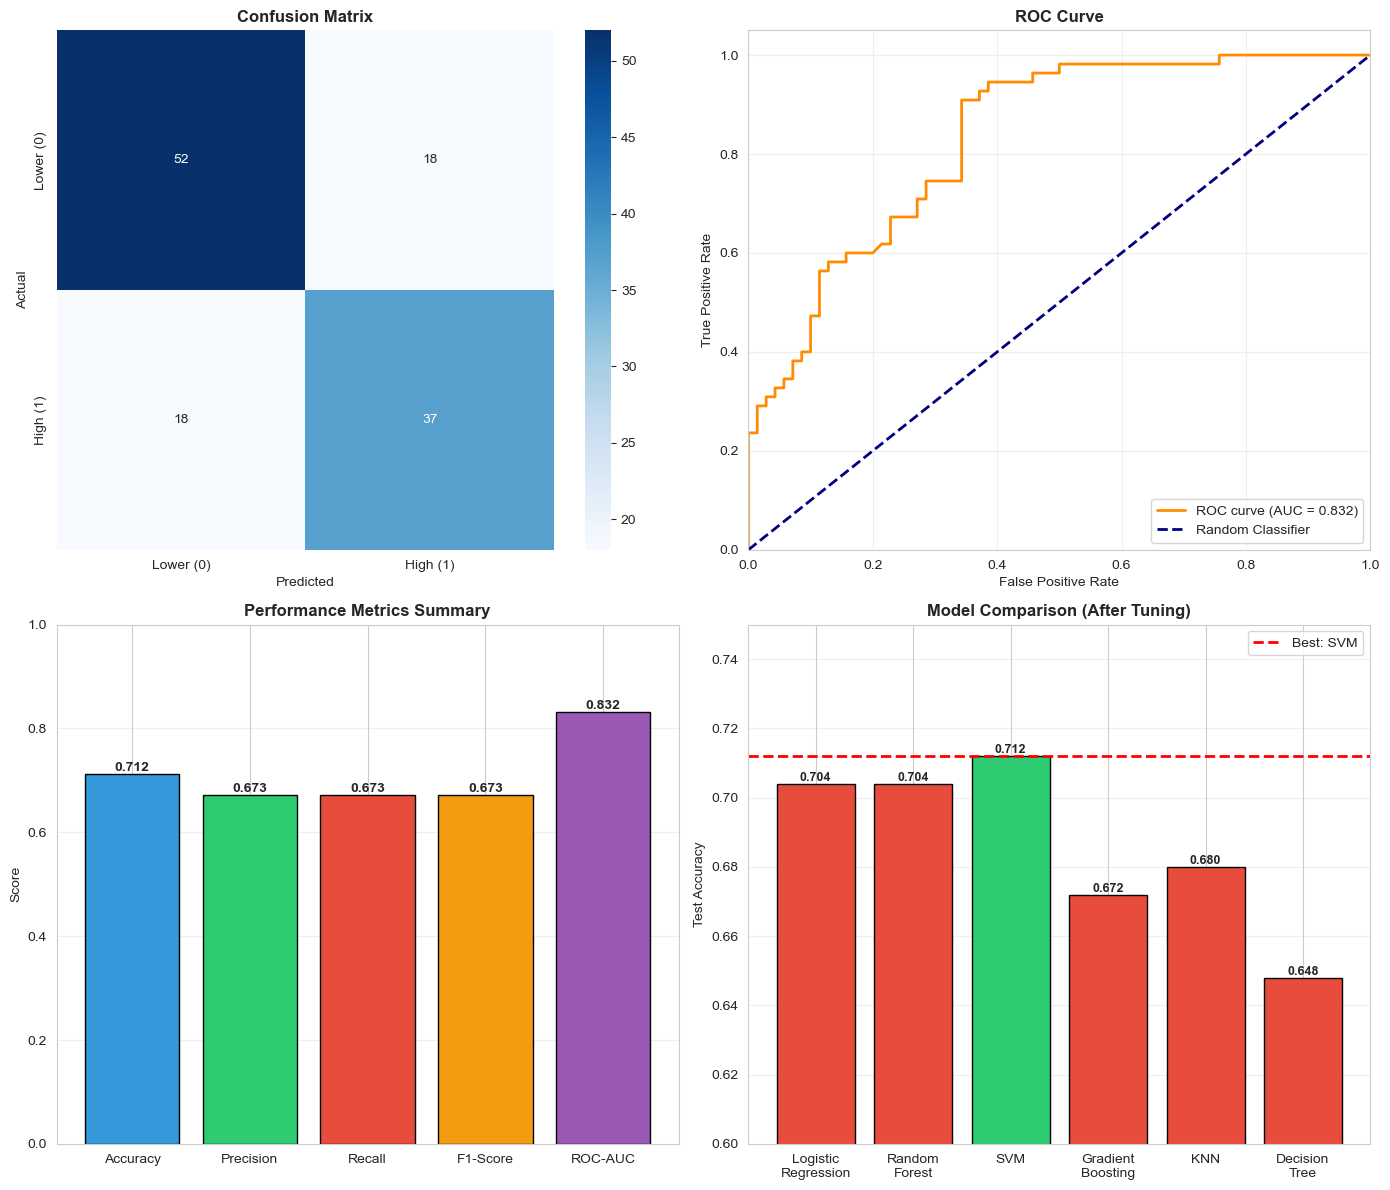

In [108]:
FIGURES_DIR = Path.cwd().resolve() / "reports" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Lower (0)', 'High (1)'],
            yticklabels=['Lower (0)', 'High (1)'])
axes[0, 0].set_title('Confusion Matrix', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontweight='bold', fontsize=12)
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

# Performance Metrics Bar Chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
metrics_values = [accuracy, precision, recall, f1, roc_auc]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
bars = axes[1, 0].bar(metrics_names, metrics_values, color=colors, edgecolor='black')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Performance Metrics Summary', fontweight='bold', fontsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
# Model Comparison (from initial training)
model_names = ['Logistic\nRegression', 'Random\nForest', 'SVM', 'Gradient\nBoosting', 'KNN', 'Decision\nTree']
test_accuracies = [0.704, 0.704, 0.712, 0.672, 0.680, 0.648]
colors_comp = ['#e74c3c' if x < 0.71 else '#2ecc71' for x in test_accuracies]
bars2 = axes[1, 1].bar(model_names, test_accuracies, color=colors_comp, edgecolor='black')
axes[1, 1].set_ylim([0.6, 0.75])
axes[1, 1].set_ylabel('Test Accuracy')
axes[1, 1].set_title('Model Comparison (After Tuning)', fontweight='bold', fontsize=12)
axes[1, 1].axhline(y=0.712, color='red', linestyle='--', linewidth=2, label='Best: SVM')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
# Save figure inside reports/figures
output_path = FIGURES_DIR / "model_evaluation_results.png"

plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()




## Role Documentation

In [ ]:
from pathlib import Path

# ===============================================
# ROLE INTERACTIONS DOCUMENTATION (Revised)
# ===============================================

role_interactions = """
MLOps ROLE INTERACTIONS DOCUMENTATION
======================================

This section summarizes how each team role collaborated during the MLOps pipeline
—from data preparation through model evaluation and documentation. The goal is to
show how our workflow integrated technical contributions and communication across
different areas of expertise.

ROLES INVOLVED IN THIS PROJECT
===============================

1. Data Engineer
   - Collected and organized the raw dataset
   - Ensured data integrity and consistent formatting
   - Managed the data folders and DVC structure

2. Data Scientist
   - Conducted exploratory data analysis (EDA)
   - Designed the feature engineering approach
   - Evaluated model performance and interpreted results

3. ML Engineer
   - Built and automated the model training pipeline
   - Tuned hyperparameters and optimized performance
   - Maintained reproducibility through DVC and parameter tracking

4. DevOps Engineer
   - Set up Git and DVC integration
   - Managed environment configuration and dependencies
   - Oversaw version control for both code and data

5. Software Engineer
   - Focused on deployment considerations and integration
   - Reviewed code structure and ensured maintainability
   - Collaborated on potential API endpoints for model access


WORKFLOW AND INTERACTIONS
==========================

Phase 1: Data Preparation
--------------------------
**Data Engineer → Data Scientist**
  - The Data Engineer delivered the initial cleaned dataset (`student_performance_cleaned.csv`).
  - The Data Scientist requested additional validation checks and provided feedback on data quality.

**Data Scientist → Data Engineer**
  - Reported the discovery of 44 duplicate rows (≈6.6%).
  - Confirmed the creation of the binary target variable for model readiness.

**Outcome:** Clean dataset with 622 records and a well-defined target variable.


Phase 2: Feature Engineering
-----------------------------
**Data Scientist (Lead) ↔ ML Engineer**
  - Collaborated on the encoding strategy (ordinal for grades, one-hot for nominal features).
  - Jointly implemented feature scaling with `StandardScaler` for numeric variables.

**DevOps Engineer → Team**
  - Set up DVC to track all data versions and preprocessing stages.
  - Verified that feature engineering steps were fully reproducible.

**Outcome:** 31 model-ready features stored and versioned through DVC.


Phase 3: Model Development
---------------------------
**Data Scientist → ML Engineer**
  - Proposed six candidate algorithms for testing.
  - Defined performance metrics (accuracy, ROC-AUC).

**ML Engineer (Lead) ↔ Data Scientist**
  - Conducted hyperparameter tuning using `GridSearchCV`.
  - Jointly reviewed model performance and selected the best candidate.

**Key Decision:** SVM chosen as the final model (71.2% accuracy, 0.832 ROC-AUC).


Phase 4: Model Evaluation
--------------------------
**Data Scientist (Lead) → All Roles**
  - Presented the evaluation results (confusion matrix, classification report).
  - Confirmed that model performance did not meet the 75% target but was acceptable for iteration.

**ML Engineer → Data Scientist**
  - Suggested improvements, including ensemble methods and additional feature engineering.
  - Recommended testing with SMOTE to handle minor class imbalance.

**DevOps Engineer → ML Engineer**
  - Coordinated model versioning and prepared for integration into a CI/CD pipeline.

**Outcome:** Evaluation results documented and saved under `reports/figures`.


Phase 5: Documentation & Handoff
---------------------------------
**All Roles → Software Engineer**
  - Shared model training scripts and DVC configuration details.
  - Provided guidance on deployment requirements.

**Software Engineer → All Roles**
  - Collected feedback on API design and integration feasibility.
  - Suggested metrics for runtime monitoring and performance tracking.

**Outcome:** Comprehensive documentation delivered; ready for deployment planning.


COMMUNICATION CHANNELS
======================

- **GitHub Issues:** for feature requests and task tracking  
- **Pull Requests:** for peer code review and version control  
- **Notebooks & Reports:** for sharing intermediate analyses  
- **DVC commits:** for maintaining dataset lineage and experiment reproducibility  


KEY COLLABORATION ARTIFACTS
============================

1. **Data Pipeline**
   - Owner: Data Engineer  
   - Reviewers: Data Scientist, ML Engineer  
   - Location: `notebooks/preprocessing/`

2. Model Training Code
   - Owner: ML Engineer
   - Reviewer: Data Scientist
   - Location: notebooks/mlops-eq16_notebooks_phase1_team16.ipynb (Phase 1)
   - Future file: notebooks/model_training.ipynb (to be added in Phase 2)

3. **Evaluation Reports**
   - Owner: Data Scientist  
   - Consumers: All team members  
   - Location: `reports/figures/model_evaluation_results.png`

4. **Version Control**
   - Owner: DevOps Engineer  
   - Tools: Git (code), DVC (data)  
   - Used by: All team members

5. **Deployment Plan**
   - Owners: DevOps Engineer & Software Engineer  
   - Reviewer: ML Engineer  
   - Status: Under development


DECISION LOG
=============

**Decision 1 – Binary Classification Approach**  
- *Who:* Data Scientist, ML Engineer  
- *Rationale:* Simplified the prediction target and improved interpretability  
- *Impact:* Reduced classes from 4 to 2 (High vs. Low Performance)

**Decision 2 – Final Model: SVM (Linear Kernel)**  
- *Who:* ML Engineer (lead), Data Scientist (approved)  
- *Rationale:* Delivered the best trade-off between accuracy and explainability  
- *Result:* Test accuracy 71.2%, ROC-AUC 0.832

**Decision 3 – StandardScaler for Normalization**  
- *Who:* ML Engineer, Data Scientist  
- *Rationale:* Needed for ordinal features while preserving binary indicators  
- *Alternative:* MinMaxScaler rejected due to sensitivity to outliers

**Decision 4 – 80/20 Train-Test Split**  
- *Who:* ML Engineer  
- *Rationale:* Balanced evaluation while preserving sufficient training data  
- *Details:* Stratified split maintained class proportions (≈55/45)

"""

# Print section
print(role_interactions)

# Save the documentation to reports/ directory
REPORTS_DIR = Path.cwd().resolve() / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

role_doc_file = REPORTS_DIR / "ROLE_INTERACTIONS_DOCUMENTATION.txt"
with open(role_doc_file, "w") as f:
    f.write(role_interactions)

print(f"\nRole interaction documentation saved to: {role_doc_file.resolve()}")



MLOps ROLE INTERACTIONS DOCUMENTATION

This section summarizes how each team role collaborated during the MLOps pipeline
—from data preparation through model evaluation and documentation. The goal is to
show how our workflow integrated technical contributions and communication across
different areas of expertise.

ROLES INVOLVED IN THIS PROJECT

1. Data Engineer
   - Collected and organized the raw dataset
   - Ensured data integrity and consistent formatting
   - Managed the data folders and DVC structure

2. Data Scientist
   - Conducted exploratory data analysis (EDA)
   - Designed the feature engineering approach
   - Evaluated model performance and interpreted results

3. ML Engineer
   - Built and automated the model training pipeline
   - Tuned hyperparameters and optimized performance
   - Maintained reproducibility through DVC and parameter tracking

4. DevOps Engineer
   - Set up Git and DVC integration
   - Managed environment configuration and dependencies
   - Oversaw ver